### Summary of classes, methods, and functions for analyzing the Piezo experiment.

* combine with pre-processing steps for the non-piezo experiments.

* change the test directory to the shared_data.

> For making synchronized videos of two-photon imaging and high-speed video recordings both with or without the registrations use and modify (to make mean z-projection if necessary) the functions in : 20220114_nompA-GFP_Iav-tdTomato_fast_z_movie_use_class_and_config_yaml_for20220114.ipynb

(We need to adjust for the multiple z-level analysis to make the projected image for the video).



* based on latests classes and functions for piezo analysis:


> * Initial part is based on classes defined in: 20210823_Revised4_independent_z_piezo_analysis_multiple_zlevel_use_class_and_config_yaml_20210823_4


> * ROI selction part is based on a class defined in:
 20210829_Re2_select_ROI_for_piezo_response_individual_z_20210712_to_20210823.ipynb
 and
  
>  * 20210828_Re_select_right_left_club_dendritic_tip_20210712-0823.ipynb




> * Center of the response calculation is based on:
20210903_Re4_Calculate_center_of_piezo_response_20210712_to_0823.ipynb



> * Rotating the center of the response is based on:
20210903_Re3_center_and_rotate_the_center_of_response_piezo_response_run_for_all_50percent.ipynb



> * Calculating the average response for each frequency is based on:
20210903_piezo_response_frequency_tuning_curve_20210712_to_0823.ipynb



> * Plotting the average response curve vs frequency is based on:
20220429_Re_plot_piezo_response_frequency_tuning_curve_20210712_to_0823



> * making an example DF/F map is based on:
20220428_Re_make_example_DF_F_map_with_response_center.ipynb

> * plotting the summary of response locations and bootstrap analysis of the difference in the response location is based on: 20220502_Re4_club_vibration_response_plots_PCA_bootstrap_analysis_for_all_50percent














### Install ScanImage Tiff Reader provided by Vidriotech

In [1]:
#Install ScanImage Tiff Reader for Python
!pip install scanimage-tiff-reader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 10.1 MB/s 
  Created wheel for scanimage-tiff-reader: filename=scanimage_tiff_reader-1.4.1-cp37-cp37m-manylinux1_x86_64.whl size=1010327 sha256=3f66b134b83adae4346e8ed82a38850ac900000c9ed819bc1f037c9e7eb2c0ca
  Stored in directory: /root/.cache/pip/wheels/be/9a/0b/7fe4a277c98b92046cac959c9e22514f4a773708f48a740206
Successfully built scanimage-tiff-reader


### Mount the Google Drive (Shared drives)

In [2]:
#link to the google drive. Need to follow the authorization instructions.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Latest class for preprocessing of all two-photon recordings and analying Piezo experiments.

* based on 20210823 version for now.
* but has been added and modified as written above.



In [10]:
#Import packages
from ScanImageTiffReader import ScanImageTiffReader
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter, center_of_mass
import pickle
import scipy.signal
import re
import pandas as pd
import seaborn as sns
import cv2
import yaml

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

#for interactive selection.
import IPython.display as Disp
from ipywidgets import widgets

import matplotlib

from scipy.stats import bootstrap
from sklearn.decomposition import PCA
from sklearn.utils import resample

# Define a class "image_preprocessing_separate_z" for preprocess all two-photon calcium imaging data
#and also analyzing imaging data in response to the
#vibration stimuli (high frequency vibration with Piezo).
#Includes, preprocessing (demulitplexing, filtering, motion-correction),
#making exaple video (synchronizing video images with two-photon images by detecting frame signals),
# and generating response maps (detecting frames where vibration stimuli occured and making DF/F and DR/R maps).
#This class will keep all z-levels separate until the end where we make the DR/R and DF/F.

class image_preprocessing_separate_z:
  """
  This class initializes a image_preprocessing_separate_z objects with attributes: data_file_path, frame_signal_filepath,
  config_filepath, etc (all parameters are included in the config.yaml configuration file)
  and methods: filter_ScanImageFile_separate_z, motion_correction_separate_z, detect_camera_imaging_frames2,
  detect_piezo_start_frames, make_synchronized_video_gray_piezo, get_piezo_response_map_separate_z,
  and merge_piezo_response_map
  """
  def __init__(self,data_filepath,frame_signal_filepath,config_filepath):
    
    with open(config_filepath, "r") as file:
            config = yaml.safe_load(file) # read from config.yaml

    self.gaussian_sigma = config[0]['gaussian_filter']
    self.number_of_channels = config[0]['number_of_channels']
    self.camera_channel = config[0]['camera_channel']
    self.imaging_channel = config[0]['imaging_channel']
    self.piezo_channel = config[0]['piezo_channel']
    self.c_height = config[0]['c_height']
    self.c_width = config[0]['c_width']
    self.c_distance = config[0]['c_distance']
    self.i_height = config[0]['i_height']
    self.i_width = config[0]['i_width']
    self.i_distance = config[0]['i_distance']
    self.window_width = config[0]['window_width']
    self.skip_interval = config[0]['skip_interval']

    self.n_of_z = config[0]['n_of_z']
    self.frames_per_second = config[0]['frames_per_second']
    self.min_range1 = config[0]['min_range1']
    self.max_range1 = config[0]['max_range1']
    self.min_range2 = config[0]['min_range2']
    self.max_range2 = config[0]['max_range2']
    self.min_range3 = config[0]['min_range3']
    self.max_range3 = config[0]['max_range3']
    self.gcamp_threshold_ratio = config[0]['gcamp_threshold_ratio']
    self.tdTomato_threshold = config[0]['tdTomato_threshold']
    self.ratio_threshold = config[0]['ratio_threshold']
    self.response_range = config[0]['response_range']
    self.base_range = config[0]['base_range']

    self.upsample = config[0]['upsample']
    self.registration_channel = config[0]['registration_channel']

    self.data_filepath = data_filepath
    self.frame_signal_filepath = frame_signal_filepath
    self.gcamp_filtered_path = None 
    self.tdTomato_filtered_path = None
    self.gcamp_registered_path = None
    self.tdTomato_registered_path = None
    self.frame_data_path = None
    self.piezo_data_path = None
    self.map_data_path = None
    self.merged_path = None

  
  def filter_ScanImageFile_separate_z(self):
    """
    This method loads the image generated by scanImage, demultiplex it into
    green and red channels, divide into each z-level, and gaussian filter it 
    with the specified gamma. This method will keep all z-levels separate rather
    than collapsing them together.
    Recommended gauusian gamma [0, 5, 5] for single Z recording with upstairs 2P.
    [3, 5, 5] for single Z downstairs 2P.
    [1, 5, 5] for fast-Z recordings?
    """
    #
    file_name=self.data_filepath
    gaussian_sigma_array=self.gaussian_sigma
    n_of_z=self.n_of_z

    #Load the image using ScanImageTiffReader
    TimeSeries=ScanImageTiffReader(file_name).data()
    #Close the file
    ScanImageTiffReader(file_name).close()
    
    #Currently the images are multiplexed so NofFrames*NoChannels*n_of_z
    #is the first dimension.

    #We first split into two channels because we know they all have two channels
    #for the 1st channel (start with 1 and take every other frame)
    Channel_1_Index=np.arange(0, TimeSeries.shape[0],2)
    Channel_2_Index=np.arange(1,TimeSeries.shape[0],2)

    #assuming GCaMP is channel 1 and tdT is channel 2
    #This is true for all downstairs experiments

    GCaMPSignal=TimeSeries[Channel_1_Index]
    tdTomatoSignal=TimeSeries[Channel_2_Index]
    del TimeSeries

    #Split into different z-levels and apply 3D gaussian filter
    #First for the GCaMP signal.
    depth_avg_image_GCaMP=np.zeros((n_of_z,GCaMPSignal.shape[0]//n_of_z,GCaMPSignal.shape[1],GCaMPSignal.shape[2]))

    for depth in range(n_of_z):
        depthIndex=np.arange(depth,GCaMPSignal.shape[0],n_of_z)
        depth_avg_image_GCaMP[depth,:,:,:] = gaussian_filter(GCaMPSignal[depthIndex], sigma=gaussian_sigma_array)
    
    #save the depth_avg_image
    image_file_name=file_name.split('.')
    GCaMP_name=(image_file_name[0]+"GCaMP_Filtered_Zs")
    print(GCaMP_name)
    with open(GCaMP_name, "wb") as f:
      pickle.dump(depth_avg_image_GCaMP,f)
    del depth_avg_image_GCaMP

    #Do the same for the tdTomato signal.
    depth_avg_image_tdTomato=np.zeros((n_of_z,tdTomatoSignal.shape[0]//n_of_z,tdTomatoSignal.shape[1],tdTomatoSignal.shape[2]))

    for depth in range(n_of_z):
        depthIndex=np.arange(depth,tdTomatoSignal.shape[0],n_of_z)
        depth_avg_image_tdTomato[depth,:,:,:] = gaussian_filter(tdTomatoSignal[depthIndex], sigma=gaussian_sigma_array)
    
    #save the depth_avg_image
    image_file_name=file_name.split('.')
    tdTomato_name=(image_file_name[0]+"tdTomato_Filtered_Zs")
    print(tdTomato_name)
    with open(tdTomato_name, "wb") as f:
      pickle.dump(depth_avg_image_tdTomato,f)
    del depth_avg_image_tdTomato

    self.gcamp_filtered_path = GCaMP_name 
    self.tdTomato_filtered_path = tdTomato_name

    return self.gcamp_filtered_path, self.tdTomato_filtered_path

  def motion_correction_separate_z(self):

    """
    This method loads the filtered image data, and register
    individual images to the average image. Use subpixel registration algorithm
    that uses FFT. Use the registration_channel to register images. Use the same
    shift for both channels in the two-photon images.
    """
    registration_channel=self.registration_channel
    gcamp_filtered_path = self.gcamp_filtered_path
    tdTomato_filtered_path = self.tdTomato_filtered_path
    upsample = self.upsample
    n_of_z = self.n_of_z

    #This version keeps each z level separate and register each one.
    ### For now use the average of gaussian filtered data to register the images.
    #use the registration channel to correct for motion.
    #apply the same shift to the other channel.

    #Get filtered images for registration channel
    if registration_channel==1:
      #use gcamp signal to register
      with open(gcamp_filtered_path, "rb") as f:
        filtered_images=pickle.load(f)
      #load the tdTomato signal as well
      with open(tdTomato_filtered_path, "rb") as f:
        filtered_images2=pickle.load(f)
    else:
      #use tdTomato signal to register
      with open(tdTomato_filtered_path, "rb") as f:
        filtered_images=pickle.load(f)
      #load the gcamp signal as well
      with open(gcamp_filtered_path, "rb") as f:
        filtered_images2=pickle.load(f)

    #filtered_images is np array with [n_of_z, frames, rows, columns]
    n_of_frames=filtered_images.shape[1]

    #initialize an array with the same size and data type as filtered images
    registered_images=np.zeros_like(filtered_images)
    registered_images2=np.zeros_like(filtered_images2)
  
    #run motion correction for each z-level.
    for z_level in range(n_of_z):
      #make an average image to register to.
      average_image=np.mean(filtered_images[z_level,:,:,:],axis=0)
    
      for frame in range(n_of_frames):

        # subpixel precision
        shift, error, diffphase = phase_cross_correlation(average_image, filtered_images[z_level,frame,:,:],upsample_factor=upsample)
        #correct for the movement
        new_image = fourier_shift(np.fft.fftn(filtered_images[z_level,frame,:,:]), shift)
        new_image2 = fourier_shift(np.fft.fftn(filtered_images2[z_level,frame,:,:]), shift)
        new_image = np.fft.ifftn(new_image)
        new_image2 = np.fft.ifftn(new_image2)
        new_image = new_image.real
        new_image2 = new_image2.real
        registered_images[z_level,frame,:,:]=new_image
        registered_images2[z_level,frame,:,:]=new_image2
  
    #Save the registered images
    if registration_channel==1:

      #we used gcamp signal to register.
      outfile_name=(gcamp_filtered_path+"_registered_Zs")
      print(outfile_name)
      with open(outfile_name, "wb") as f:
        pickle.dump(registered_images,f)
      self.gcamp_registered_path = outfile_name
      #Also save tdTomato signals
      outfile_name=(tdTomato_filtered_path+"_registered_Zs")
      print(outfile_name)
      with open(outfile_name, "wb") as f:
        pickle.dump(registered_images2,f)
      self.tdTomato_registered_path = outfile_name

    else:
      #we used tdTomato signal to register.
      outfile_name=(tdTomato_filtered_path+"_registered_Zs")
      print(outfile_name)
      with open(outfile_name, "wb") as f:
        pickle.dump(registered_images,f)
      self.tdTomato_registered_path = outfile_name
      #Also save gcamp signals
      outfile_name=(gcamp_filtered_path+"_registered_Zs")
      print(outfile_name)
      with open(outfile_name, "wb") as f:
        pickle.dump(registered_images2,f)
      self.gcamp_registered_path = outfile_name

       
    
    return self.gcamp_registered_path, self.tdTomato_registered_path


  def detect_camera_imaging_frames2(self):
    """
    a method for finding the match between the imaging frame and the camera frames.
    
    * each object should have the path to the frame info file.
    * number_of_channels: number of channels in the data. Should be 7.
    * camera_channel: the channel that contains the camera exposure signal. Should be channel 1 (2nd channel).
    * imaging_channel: the channel that contains the imaging frame signal. Should be channel 2 (3rd channel).
    * c_height, c_width, c_distance: parameters for detecting camera signal with scipy.signal.findpeaks
    * i_height, i_width, i_distance: same for the imaging frames.
    * window_width: window to average the frame signals (necessary if sampling rate is too high). Should be 10.
    """
    input_file=self.frame_signal_filepath

    number_of_channels=self.number_of_channels
    camera_channel=self.camera_channel
    imaging_channel = self.imaging_channel
    c_height = self.c_height
    c_width = self.c_width
    c_distance = self.c_distance
    i_height = self.i_height
    i_width = self.i_width
    i_distance = self.i_distance
    window_width = self.window_width


    #read the binary file.
    frame_data=np.fromfile(input_file)
    
    #Check the number of data points
    number_of_data=frame_data.shape[0]
    
    #Get the camera exposure signal
    camera_frame_signal_index=np.arange(camera_channel,number_of_data,number_of_channels)
    camera_frame_signal=frame_data[camera_frame_signal_index]
    
    #Get the image frame signal
    image_frame_signal_index=np.arange(imaging_channel,number_of_data,number_of_channels)
    image_frame_signal=frame_data[image_frame_signal_index]
    #Convolve the image_frame_signal
    image_frame_signal=np.convolve(image_frame_signal,np.ones((window_width,))/window_width, mode='valid')
    
    
    #See how the camera signal changes and find the peaks
    camera_diff=np.diff(camera_frame_signal)
    #Use scipy.signal.find_peaks to get the peaks in the diff data.
    peaks_camera, _ =scipy.signal.find_peaks(camera_diff,height=c_height, width=c_width, distance=c_distance)

    #Do the same for the imaging signal
    image_diff=np.diff(image_frame_signal)
    #Use scipy.signal.find_peaks to get the peaks in the diff data.
    peaks_image, _ =scipy.signal.find_peaks(image_diff,height=i_height, width=i_width, distance=i_distance)

    #plot to camera and frame interval to check the detection.
    camera_interval=np.diff(peaks_camera)
    plt.figure(figsize=(10,3))
    plt.plot(camera_interval)
    sns.despine()
    
    image_interval=np.diff(peaks_image)
    plt.figure(figsize=(10,3))
    plt.plot(image_interval)
    sns.despine()
    
    #Go through each imaging frame and find the camera frame with the closest index
    #This camera frame will be closest to the beginning of the image acquisition.
    image_in_camera_index=np.zeros((peaks_image.shape[0],1), dtype=np.int)

    #keep track of how far away the camera signal was relative to the imaging signal.
    camera_minus_image_index=np.zeros((peaks_image.shape[0],1), dtype=np.int)

    for n in range(peaks_image.shape[0]):
        #take the absolute difference in the index between the image acquisition and all camera images
        time_to_camera=np.absolute(peaks_camera-peaks_image[n])
        #Find the camera image that is closest (frame number)
        image_in_camera_index[n]=np.argmin(time_to_camera)
        #find the time between the image peak and the closest camera peak. positive indicates that the camera began after the start of image acquisition
        camera_minus_image_index[n]=peaks_camera[image_in_camera_index[n]]-peaks_image[n]
    
    #Save the two index in a pickle file
    new_file_name=input_file+'frame_data'

    with open(new_file_name, "wb") as f:
      pickle.dump([image_in_camera_index,camera_minus_image_index], f)
    print(new_file_name)

    self.frame_data_path = new_file_name 

    return self.frame_data_path

  def detect_piezo_start_frames(self):
    """
    a method for finding the imaging frame where the piezo stimulus starts.
    
    * each object should have the path to the frame info file.
    * number_of_channels: number of channels in the data. Should be 7.
    * piezo_channel: the channel that contains the piezo signal. Should be channel 6.
    * imaging_channel: the channel that contains the imaging frame signal. Should be channel 2 (3rd channel). 
    * i_height, i_width, i_distance: parameters for detecting image frame signal with scipy.signal.findpeaks.
    * window_width: window to average the frame signals (necessary if sampling rate is too high). Should be 10.
    * n_of_z: number of z-levels in the fast-z image stack
    * skip_interval: number of samples to skip from the initial piezo start for the detection of the second stimulus
    """
    input_file=self.frame_signal_filepath

    number_of_channels=self.number_of_channels
    piezo_channel=self.piezo_channel
    imaging_channel = self.imaging_channel
    i_height = self.i_height
    i_width = self.i_width
    i_distance = self.i_distance
    window_width = self.window_width
    n_of_z = self.n_of_z
    skip_interval = self.skip_interval


    #read the binary file.
    frame_data=np.fromfile(input_file)
    
    #Check the number of data points
    number_of_data=frame_data.shape[0]

    #Get the piezo signal
    piezo_signal_index=np.arange(piezo_channel,number_of_data,number_of_channels)
    piezo_signal=frame_data[piezo_signal_index]

    #find when the piezo was on: define "On" as time point that it reaches half max amplitude.
    piezo_threshold=(np.max(piezo_signal)-np.min(piezo_signal))/2+np.min(piezo_signal)
    piezo_on=piezo_signal>=piezo_threshold
    
    #find first start
    first_start=np.argmax(piezo_on)

    #Find second start: hard coded for now
    second_start=np.argmax(piezo_on[first_start+skip_interval:])+first_start+skip_interval
    
    #Get the image frame signal
    image_frame_signal_index=np.arange(imaging_channel,number_of_data,number_of_channels)
    image_frame_signal=frame_data[image_frame_signal_index]
    #Convolve the image_frame_signal
    image_frame_signal=np.convolve(image_frame_signal,np.ones((window_width,))/window_width, mode='valid')
    
    #see how the image signal changes
    image_diff=np.diff(image_frame_signal)
    #Use scipy.signal.find_peaks to get the peaks in the diff data.
    peaks_image, _ =scipy.signal.find_peaks(image_diff,height=i_height, width=i_width, distance=i_distance)
    
    image_interval=np.diff(peaks_image)
    plt.figure(figsize=(10,3))
    plt.plot(image_interval)
    sns.despine()
    
    #we need to divide by n_of_z to convert to the volume number from the frame number
    
    #Find the frame that's closest to the piezo start
    time_to_piezo=np.absolute(peaks_image-first_start)
    #Find the image that is closest (frame number)
    first_piezo_frame=np.argmin(time_to_piezo)
    #Find the volume that started after the piezo on.
    first_piezo_frame=first_piezo_frame//n_of_z+1
    print(first_piezo_frame)

    #Find the frame that's closest to the second start
    #Find the frame that's closest to the piezo start
    time_to_piezo=np.absolute(peaks_image-second_start)
    #Find the image that is closest (frame number)
    second_piezo_frame=np.argmin(time_to_piezo)
    second_piezo_frame=second_piezo_frame//n_of_z+1
    print(second_piezo_frame)

    #Save the two start times in a pickle file
    new_file_name=input_file+'piezo_data'

    with open(new_file_name, "wb") as f:
      pickle.dump([first_piezo_frame,second_piezo_frame], f)
    print(new_file_name)

    self.piezo_data_path = new_file_name 

    return self.piezo_data_path



  
  def make_synchronized_video_gray(self):
    """
    Revised again to use the z projection of the independent-z filtered and
    registered images.

    revised slightly to use the registered images for GCaMP. Change later to 
    register both images (currently some don't have tdTomato) and use registered
    version of both images.

    a function to load the filtered data for both tdTomato and GCaMP, load the
    correct frame for the video, and make a synchronized .avi movie.
    *tdTomato_file: a pickle file that contains the filtered tdTomato images.
    Each object should have a path to this file
    *GCaMP_file: same for the GCaMP.
    *input_video_file: a .mp4 file that contains the prep's image from below.
    Each object should have a path to this file.
    * n_of_z: number of z levels
    * frame_data: a pickle file that contains the frame info. Each object should
    have a path to this file.
    * frames_per_second: defines how many fps for the video.
    *min_range and max_range defines the min and max for the tdTomato (1) and GCaMP (2) image.

    self.video_filepath = video_filepath
    self.gcamp_filtered_path = None 
    self.tdTomato_filtered_path = None
    self.frame_data_path = None
    """
    tdTomato_file=self.tdTomato_registered_path
    GCaMP_file=self.gcamp_registered_path
    frame_data=self.frame_data_path
    input_video_file=self.video_filepath

    n_of_z = self.n_of_z
    frames_per_second = self.frames_per_second
    min_range1 = self.min_range1
    max_range1 = self.max_range1
    min_range2 = self.min_range2
    max_range2 = self.max_range2

    #Get tdTomato images
    with open(tdTomato_file, "rb") as f:
      tdTomato_Filtered=pickle.load(f)
    #Get GCaMP images
    with open(GCaMP_file, "rb") as f:
      GCaMP_Filtered=pickle.load(f)
    #Get frame data
    with open(frame_data, "rb") as f:
      [image_in_camera_index,camera_minus_image_index]=pickle.load(f)
    
    #If the filtered/registered images have a 4th dimension (registered and filtered for each z in 
    #an multi-z stack) make z projection.
    if len(tdTomato_Filtered.shape) == 4:
      tdTomato_Filtered = np.mean(tdTomato_Filtered, axis = 0)
      GCaMP_Filtered = np.mean(GCaMP_Filtered, axis = 0)

    #Number of frames should be the same for tdTomato and GCaMP.
    total_frames=tdTomato_Filtered.shape[0]
    x_size=tdTomato_Filtered.shape[2]#number of columns
    y_size=tdTomato_Filtered.shape[1]#number of rows
    #image_in_camera_index has a value for each z-level. Take the index for each stack.
    stack_camera_index=image_in_camera_index[0::n_of_z,0]

    #Make a video with the tdTomato signal + GCaMP signal + prep image
    video_name = (tdTomato_file+"synchronized_video_gray.avi")
    #Image width will be 2 * imaging_width + re-sized video (width:height is 4:3 ratio if preserving the aspct): specify width first.
    #We want to make the heights to match.
    resized_video_width=(y_size//3)*4
    #Final "0" necessary for gray scale image
    video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'mp4v'),frames_per_second,(x_size*2+resized_video_width,y_size),0)


    #For making video, all numbers below min_range1 will be treated as 0.
    #all numbers above max_range1 will be treated as max_range1 value.
    #Then normalize the image to be between 0 to 255.
    tdTomato_Filtered[tdTomato_Filtered<=min_range1]=0
    tdTomato_Filtered[tdTomato_Filtered>=max_range1]=max_range1
    range_adjusted_tdTomato=(tdTomato_Filtered/max_range1)*255

    #For GCaMP
    GCaMP_Filtered[GCaMP_Filtered<=min_range2]=0
    GCaMP_Filtered[GCaMP_Filtered>=max_range2]=max_range2
    range_adjusted_GCaMP=(GCaMP_Filtered/max_range2)*255
    
    #Open the video file
    cap = cv2.VideoCapture(input_video_file)
    max_frames = cap.get(7)
    #Initialize the frame
    frame_original=np.zeros((y_size,x_size*2+resized_video_width))

    for video_frame in range(total_frames):
      #Insert images in the right location.
      frame_original[:,0:x_size]=range_adjusted_tdTomato[video_frame,:,:]
      frame_original[:,x_size:x_size*2]=range_adjusted_GCaMP[video_frame,:,:]

      #Get the correct prep image.
      #check to make sure the frame is within the range.
      #Have 10 frame buffer
      if stack_camera_index[video_frame]<max_frames-10:
        frame_number=stack_camera_index[video_frame]
      else:
        frame_number=max_frames-10
      #print(frame_number)
      cap.set(1, frame_number)
      ret, temp_frame = cap.read()
      temp_frame=temp_frame[:,:,0]
      #resize the prep image
      new_image=cv2.resize(temp_frame,(resized_video_width, y_size),interpolation = cv2.INTER_AREA)

      #insert the prep image in the right location. The above should already be in 0-255 range.
      frame_original[:,x_size*2:x_size*2+resized_video_width]=new_image
      #convert to gray scale color image
      #frame = cv2.cvtColor(np.int8(frame_original), cv2.COLOR_GRAY2BGR)
      #frame = cv2.applyColorMap(np.uint8(frame_original),cv2.COLORMAP_BONE)
      frame=np.uint8(frame_original)
      
      video.write(frame)

    video.release()




  def make_synchronized_video_gray_no_registration(self):
    """
    revised to deal with the case where we have multiple z- levels.
    revised slightly to use the filtered images only. For imaging from the leg where the cells move

    a function to load the filtered data for both tdTomato and GCaMP, load the
    correct frame for the video, and make a synchronized .avi movie.
    *tdTomato_file: a pickle file that contains the filtered tdTomato images.
    Each object should have a path to this file
    *GCaMP_file: same for the GCaMP.
    *input_video_file: a .mp4 file that contains the prep's image from below.
    Each object should have a path to this file.
    * n_of_z: number of z levels
    * frame_data: a pickle file that contains the frame info. Each object should
    have a path to this file.
    * frames_per_second: defines how many fps for the video.
    *min_range and max_range defines the min and max for the tdTomato (1) and GCaMP (2) image.

    self.video_filepath = video_filepath
    self.gcamp_filtered_path = None 
    self.tdTomato_filtered_path = None
    self.frame_data_path = None
    """
    tdTomato_file=self.tdTomato_filtered_path
    GCaMP_file=self.gcamp_filtered_path
    frame_data=self.frame_data_path
    input_video_file=self.video_filepath

    n_of_z = self.n_of_z
    frames_per_second = self.frames_per_second
    min_range1 = self.min_range1
    max_range1 = self.max_range1
    min_range2 = self.min_range2
    max_range2 = self.max_range2

    #Get tdTomato images
    with open(tdTomato_file, "rb") as f:
      tdTomato_Filtered=pickle.load(f)
    #Get GCaMP images
    with open(GCaMP_file, "rb") as f:
      GCaMP_Filtered=pickle.load(f)
    #Get frame data
    with open(frame_data, "rb") as f:
      [image_in_camera_index,camera_minus_image_index]=pickle.load(f)
    
    #If the filtered/registered images have a 4th dimension (registered and filtered for each z in 
    #an multi-z stack) make z projection.
    if len(tdTomato_Filtered.shape) == 4:
      tdTomato_Filtered = np.mean(tdTomato_Filtered, axis = 0)
      GCaMP_Filtered = np.mean(GCaMP_Filtered, axis = 0)

    #Number of frames should be the same for tdTomato and GCaMP.
    total_frames=tdTomato_Filtered.shape[0]
    x_size=tdTomato_Filtered.shape[2]#number of columns
    y_size=tdTomato_Filtered.shape[1]#number of rows
    #image_in_camera_index has a value for each z-level. Take the index for each stack.
    stack_camera_index=image_in_camera_index[0::n_of_z,0]

    #Make a video with the tdTomato signal + GCaMP signal + prep image
    video_name = (tdTomato_file+"synchronized_video_gray.avi")
    #Image width will be 2 * imaging_width + re-sized video (width:height is 4:3 ratio if preserving the aspct): specify width first.
    #We want to make the heights to match.
    resized_video_width=(y_size//3)*4
    #Final "0" necessary for gray scale image
    video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'mp4v'),frames_per_second,(x_size*2+resized_video_width,y_size),0)


    #For making video, all numbers below min_range1 will be treated as 0.
    #all numbers above max_range1 will be treated as max_range1 value.
    #Then normalize the image to be between 0 to 255.
    tdTomato_Filtered[tdTomato_Filtered<=min_range1]=0
    tdTomato_Filtered[tdTomato_Filtered>=max_range1]=max_range1
    range_adjusted_tdTomato=(tdTomato_Filtered/max_range1)*255

    #For GCaMP
    GCaMP_Filtered[GCaMP_Filtered<=min_range2]=0
    GCaMP_Filtered[GCaMP_Filtered>=max_range2]=max_range2
    range_adjusted_GCaMP=(GCaMP_Filtered/max_range2)*255
    
    #Open the video file
    cap = cv2.VideoCapture(input_video_file)
    max_frames = cap.get(7)
    #Initialize the frame
    frame_original=np.zeros((y_size,x_size*2+resized_video_width))

    for video_frame in range(total_frames):
      #Insert images in the right location.
      frame_original[:,0:x_size]=range_adjusted_tdTomato[video_frame,:,:]
      frame_original[:,x_size:x_size*2]=range_adjusted_GCaMP[video_frame,:,:]

      #Get the correct prep image.
      #check to make sure the frame is within the range.
      #Have 10 frame buffer
      if stack_camera_index[video_frame]<max_frames-10:
        frame_number=stack_camera_index[video_frame]
      else:
        frame_number=max_frames-10
      #print(frame_number)
      cap.set(1, frame_number)
      ret, temp_frame = cap.read()
      temp_frame=temp_frame[:,:,0]
      #resize the prep image
      new_image=cv2.resize(temp_frame,(resized_video_width, y_size),interpolation = cv2.INTER_AREA)

      #insert the prep image in the right location. The above should already be in 0-255 range.
      frame_original[:,x_size*2:x_size*2+resized_video_width]=new_image
      #convert to gray scale color image
      #frame = cv2.cvtColor(np.int8(frame_original), cv2.COLOR_GRAY2BGR)
      #frame = cv2.applyColorMap(np.uint8(frame_original),cv2.COLORMAP_BONE)
      frame=np.uint8(frame_original)
      
      video.write(frame)

    video.release()




  def make_synchronized_video_gray_piezo(self):
    """
    Revised to deal with the case where we have multiple z levels.
    For Piezo trials that don't have the videos.
    a method to load the filtered and registered data for both tdTomato and GCaMP
    and make a synchronized .avi movie.
    *tdTomato_file: a pickle file that contains the filtered and registered tdTomato images.
    Each object should have a path to this file
    *GCaMP_file: same for the GCaMP.
    * n_of_z: number of z levels
    * frames_per_second: defines how many fps for the video.
    *min_range and max_range defines the min and max for the tdTomato (1) and GCaMP (2) image.

  
    """
    tdTomato_file=self.tdTomato_registered_path
    GCaMP_file=self.gcamp_registered_path
    
    n_of_z = self.n_of_z
    frames_per_second = self.frames_per_second
    min_range1 = self.min_range1
    max_range1 = self.max_range1
    min_range2 = self.min_range2
    max_range2 = self.max_range2

    #Get tdTomato images
    with open(tdTomato_file, "rb") as f:
      tdTomato_Filtered=pickle.load(f)
    #Get GCaMP images
    with open(GCaMP_file, "rb") as f:
      GCaMP_Filtered=pickle.load(f)
    
    #If the filtered/registered images have a 4th dimension (registered and filtered for each z in 
    #an multi-z stack) make z projection.
    if len(tdTomato_Filtered.shape) == 4:
      tdTomato_Filtered = np.mean(tdTomato_Filtered, axis = 0)
      GCaMP_Filtered = np.mean(GCaMP_Filtered, axis = 0)

    #Number of frames should be the same for tdTomato and GCaMP.
    total_frames=tdTomato_Filtered.shape[0]
    x_size=tdTomato_Filtered.shape[2]#number of columns
    y_size=tdTomato_Filtered.shape[1]#number of rows
    
    #Make a video with the tdTomato signal + GCaMP signal + prep image
    video_name = (tdTomato_file+"synchronized_video_gray.avi")
    #Image width will be 2 * imaging_width
    #Final "0" necessary for gray scale image
    video = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'mp4v'),frames_per_second,(x_size*2,y_size),0)


    #For making video, all numbers below min_range1 will be treated as 0.
    #all numbers above max_range1 will be treated as max_range1 value.
    #Then normalize the image to be between 0 to 255.
    tdTomato_Filtered[tdTomato_Filtered<=min_range1]=0
    tdTomato_Filtered[tdTomato_Filtered>=max_range1]=max_range1
    range_adjusted_tdTomato=(tdTomato_Filtered/max_range1)*255

    #For GCaMP
    GCaMP_Filtered[GCaMP_Filtered<=min_range2]=0
    GCaMP_Filtered[GCaMP_Filtered>=max_range2]=max_range2
    range_adjusted_GCaMP=(GCaMP_Filtered/max_range2)*255
    
    #Initialize the frame
    frame_original=np.zeros((y_size,x_size*2))

    for video_frame in range(total_frames):
      #Insert images in the right location.
      frame_original[:,0:x_size]=range_adjusted_tdTomato[video_frame,:,:]
      frame_original[:,x_size:x_size*2]=range_adjusted_GCaMP[video_frame,:,:]

      frame=np.uint8(frame_original)
      
      video.write(frame)

    video.release()

  def get_piezo_response_map_separate_z(self):
    """
    a method to generate the DF/F and DR/R response map in separate z level 
    for the piezo stimulation:
    load the filtered and registered data for both tdTomato and GCaMP and calculate
    the DF/F and DR/R map during the two piezo stimuli and average them.
    *tdTomato_file: a pickle file that contains the filtered and registered tdTomato images.
    Each object should have a path to this file
    *GCaMP_file: same for the GCaMP.
    *piezo_data_file: a file that contains first and second piezo start frames (volumes)
    *min_range and max_range defines the min and max for the DF/F and DR/R images.

  
    """
    tdTomato_file=self.tdTomato_registered_path
    gcamp_file=self.gcamp_registered_path
    piezo_data_file=self.piezo_data_path
    min_range3 = self.min_range3
    max_range3 = self.max_range3
    gcamp_threshold_ratio = self.gcamp_threshold_ratio
    tdTomato_threshold = self.tdTomato_threshold
    ratio_threshold = self.ratio_threshold

    response_range = self.response_range
    base_range = self.base_range
    n_of_z = self.n_of_z

    #load the info on piezo start frame and get the tdTomato and gcamp data (filtered and registered)
    with open(piezo_data_file, "rb") as f:
      [first_piezo_start,second_piezo_start]=pickle.load(f)
    
    with open(tdTomato_file,"rb") as f:
      tdTomato_registered=pickle.load(f)
    
    with open(gcamp_file,"rb") as f:
      gcamp_registered=pickle.load(f)

    #tdTomato_registered and gcamp_registered may contain negative pixel values.
    #image brightness should always be positive (or zero), so subtract the min
    #value to make all values above zero.
    tdTomato_registered=tdTomato_registered-np.min(tdTomato_registered)
    gcamp_registered=gcamp_registered-np.min(gcamp_registered)

    #initialize the data array
    average_tdTomato_all=np.zeros((n_of_z,tdTomato_registered.shape[2],tdTomato_registered.shape[3]))
    average_gcamp_all=np.zeros_like(average_tdTomato_all)
    base_tdTomato_all=np.zeros_like(average_tdTomato_all)
    base_gcamp_all=np.zeros_like(average_tdTomato_all)
    ratio_response_all=np.zeros_like(average_tdTomato_all)
    ratio_baseline_all=np.zeros_like(average_tdTomato_all)
    DF_F_map_all=np.zeros_like(average_tdTomato_all)
    DR_R_map_all=np.zeros_like(average_tdTomato_all)

    #calculate the threshold pixel value
    flattened_array=np.ravel(base_gcamp_all)
    gcamp_sorted=np.sort(flattened_array)
    threshold_index=np.round(gcamp_sorted.shape[0]*gcamp_threshold_ratio)
    threshold_index=threshold_index.astype(int)
    gcamp_threshold=gcamp_sorted[threshold_index]

    
    #calcuate the baseline and the response images for each z-level
    for z_level in range(n_of_z):
      #
      average_tdTomato=np.average(tdTomato_registered[z_level,first_piezo_start:first_piezo_start+response_range,:,:],axis=0)
      average_tdTomato2=np.average(tdTomato_registered[z_level,second_piezo_start:second_piezo_start+response_range,:,:],axis=0)
      average_tdTomato=(average_tdTomato+average_tdTomato2)/2

      average_gcamp=np.average(gcamp_registered[z_level,first_piezo_start:first_piezo_start+response_range,:,:], axis=0)
      average_gcamp2=np.average(gcamp_registered[z_level,second_piezo_start:second_piezo_start+response_range,:,:], axis=0)
      average_gcamp=(average_gcamp+average_gcamp2)/2

      base_tdTomato=np.average(tdTomato_registered[z_level,first_piezo_start-base_range:first_piezo_start,:,:],axis=0)
      base_tdTomato2=np.average(tdTomato_registered[z_level,second_piezo_start-base_range:second_piezo_start,:,:],axis=0)
      base_tdTomato=(base_tdTomato+base_tdTomato2)/2

      base_gcamp=np.average(gcamp_registered[z_level,first_piezo_start-base_range:first_piezo_start,:,:],axis=0)
      base_gcamp2=np.average(gcamp_registered[z_level,second_piezo_start-base_range:second_piezo_start,:,:],axis=0)
      base_gcamp=(base_gcamp+base_gcamp2)/2

      #initialize the response map to zero
      ratio_response=np.zeros_like(base_gcamp)
      ratio_baseline=np.zeros_like(base_gcamp)
      DF_F_map=np.zeros_like(base_gcamp)
      DR_R_map=np.zeros_like(base_gcamp)

      #calculate ratio, but we need to exclude pixels with very low tdTomato value to avoid high noise
      ratio_response=np.divide(average_gcamp,average_tdTomato, where=((average_tdTomato>=tdTomato_threshold)&(base_tdTomato>=tdTomato_threshold)))
      ratio_baseline=np.divide(base_gcamp,base_tdTomato, where=((average_tdTomato>=tdTomato_threshold)&(base_tdTomato>=tdTomato_threshold)))

      #plot in a figure
      fig, axs = plt.subplots(1,3, figsize=(12,5),tight_layout = True)

      axs[0].imshow(base_gcamp)
      axs[0].set_yticks([])
      axs[0].set_xticks([])
      axs[0].set_title('gcamp baseline', fontsize=20)

      #DF/F calculated only for pixels whose base_gcamp value is above the threshold
      DF_F_map=np.divide((average_gcamp-base_gcamp),base_gcamp,where=(base_gcamp>=gcamp_threshold))
      # where=() in np.divide seems to give inconsitent results in google colab.
      #Force it with the following line for now.
      DF_F_map[base_gcamp<=gcamp_threshold]=0
      axs[1].imshow(DF_F_map,vmin=min_range3,vmax=max_range3)
      axs[1].set_yticks([])
      axs[1].set_xticks([])
      axs[1].set_title('DF/F map', fontsize=20)

      #DR/R calculated only for pixels whose ratio_baseline is above the threshold and we have certain level of baseline gcamp
      DR_R_map=np.divide((ratio_response-ratio_baseline),ratio_baseline,where=((ratio_baseline>=ratio_threshold)&(base_gcamp>=gcamp_threshold)))
      axs[2].imshow(DR_R_map,vmin=min_range3,vmax=max_range3)
      axs[2].set_yticks([])
      axs[2].set_xticks([])
      axs[2].set_title('DR/R map', fontsize=20)
      
      #Place in the appropriate data array.
      average_tdTomato_all[z_level,:,:]=average_tdTomato
      average_gcamp_all[z_level,:,:]=average_gcamp
      base_tdTomato_all[z_level,:,:]=base_tdTomato
      base_gcamp_all[z_level,:,:]=base_gcamp
      ratio_response_all[z_level,:,:]=ratio_response
      ratio_baseline_all[z_level,:,:]=ratio_baseline
      DF_F_map_all[z_level,:,:]=DF_F_map
      DR_R_map_all[z_level,:,:]=DR_R_map

    #Save the data array.
    outfile_name=gcamp_file+'_maps'
    
    with open(outfile_name, "wb") as f:
      pickle.dump([average_tdTomato_all,average_gcamp_all,base_tdTomato_all, base_gcamp_all, ratio_response_all, ratio_baseline_all, DF_F_map_all, DR_R_map_all], f)
    print(outfile_name)

    self.map_data_path = outfile_name 

    return self.map_data_path

  def merge_piezo_response_map(self):
    """
    a method to merge the DF/F and DR/R response map from separate z level 
    into one response map.
    load the response map and take the max response for each pixel.
    *map_data_file: a pickle file that contains all the response maps.
    *min_range and max_range defines the min and max for the DF/F and DR/R images.  
    """
    map_data_file=self.map_data_path
    min_range3 = self.min_range3
    max_range3 = self.max_range3

    #load all the response maps
    with open(map_data_file, "rb") as f:
      [average_tdTomato_all,average_gcamp_all,base_tdTomato_all, base_gcamp_all, ratio_response_all, ratio_baseline_all, DF_F_map_all, DR_R_map_all]=pickle.load(f)
    
    #take the maximum intensity projection of the responses.
    base_gcamp_projection=np.nanmax(base_gcamp_all,axis=0)
    DF_F_projection=np.nanmax(DF_F_map_all,axis=0)
    DR_R_projection=np.nanmax(DR_R_map_all,axis=0)

    #plot in a figure
    fig, axs = plt.subplots(1,3, figsize=(12,5),tight_layout = True)

    axs[0].imshow(base_gcamp_projection)
    axs[0].set_yticks([])
    axs[0].set_xticks([])
    axs[0].set_title('gcamp merged', fontsize=20)


    axs[1].imshow(DF_F_projection,vmin=min_range3,vmax=max_range3)
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_title('DF/F merged', fontsize=20)

    axs[2].imshow(DR_R_projection,vmin=min_range3,vmax=max_range3)
    axs[2].set_yticks([])
    axs[2].set_xticks([])
    axs[2].set_title('DR/R merged', fontsize=20)

    #Save the merged maps.
    outfile_name=map_data_file+'_merged'
    
    with open(outfile_name, "wb") as f:
      pickle.dump([base_gcamp_projection, DF_F_projection, DR_R_projection], f)
    print(outfile_name)

    self.merged_path = outfile_name 

    return self.merged_path


#Define a class for the interactive selection (this won't work online)

class ROI_tip_select():
    %matplotlib notebook 


    def __init__(self,im):
        self.im = im
        self.selected_points = []
        self.fig,ax = plt.subplots()
        self.img = ax.imshow(self.im.copy())
        self.ka = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
        disconnect_button = widgets.Button(description="Disconnect mpl")
        Disp.display(disconnect_button)
        disconnect_button.on_click(self.disconnect_mpl)
        
    def poly_img(self,img,pts):
        pts = np.array(pts, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(255,255,255),1)
        return img

    def onclick(self, event):
    #display(str(event))
        self.selected_points.append([event.xdata,event.ydata])
        if len(self.selected_points)>1:
            self.fig
            self.img.set_data(self.poly_img(self.im.copy(),self.selected_points))
    def disconnect_mpl(self,_):
        self.fig.canvas.mpl_disconnect(self.ka)

#A function for loading the data and initializing the mask
def load_DF_F_mask(maps_file):
  #load all the response maps
  with open(maps_file, "rb") as f:
    [average_tdTomato_all,average_gcamp_all,base_tdTomato_all, base_gcamp_all, ratio_response_all, ratio_baseline_all, DF_F_map_all, DR_R_map_all]=pickle.load(f)

  #initialize ROI_masks
  ROI_masks=np.zeros((DF_F_map_all.shape[0],DF_F_map_all.shape[1],DF_F_map_all.shape[2]),dtype=np.uint8)

  return {'DFF':DF_F_map_all, 'mask':ROI_masks}

#A function for adding the selected region to the mask
def add_to_mask(roi_polygon, ROI_masks, z_level):
  #Use the manually selected polygon to make the mask
  arr1 = np.array([roi_polygon.selected_points],'int')
  mask1 = cv2.fillPoly(np.zeros((ROI_masks.shape[1],ROI_masks.shape[2]),np.uint8),arr1,[1,1,1])

  ROI_masks[z_level,:,:]=mask1

  return ROI_masks

#A function for converting and saving the ROI_masks
def save_mask(ROI_masks, maps_path_sorted, trial_number):
  ROI_masks=ROI_masks==1

  outfile=maps_path_sorted[trial_number]+"_ROI_Z"

  with open(outfile, "wb") as f:
    pickle.dump(ROI_masks,f)
    
  print(outfile)


'''
A function for calculating the center of the response:
* use previously selected ROI
* load DF/F map (merged version)
* align the DF/F map to the standard baseline (baseline used for the ROI selection)
* use pixels that are in the ROI and above the threshold for DF/F (0.2?)
* calculate the center of the response (weighted average)
* display the center on the overlay of the GCaMP and DF/F image
* save the resutls
'''
def calculate_center_of_response(ROI_Z_file, map_file, standard_map_file, upsample):
  #Get the ROI masks for all the z-levels
  with open(ROI_Z_file,'rb') as f:
    ROI_masks=pickle.load(f)
  #Get the response maps for the individual z-levels.
  with open(map_file, "rb") as f:
    [average_tdTomato_all,average_gcamp_all,base_tdTomato_all, base_gcamp_all, ratio_response_all, ratio_baseline_all, DF_F_map_all, DR_R_map_all]=pickle.load(f)
  
  #Get the standard maps (should be the map for the 800 Hz; used to make ROI).
  with open(standard_map_file, "rb") as f:
    [standard_base_gcamp, standard_DF_F, standard_DR_R]=pickle.load(f)

  #Make the base_gcamp_projection based on the base_gcamp_all.
  base_gcamp_projection=np.nanmax(base_gcamp_all,axis=0)

  #Align all the DF/F maps based on the shift between the merged base_gcamp
  #and the standard_base_gcamp. Also make a new merged base_gcamp that's aligned.
  
  # subpixel precision
  shift, error, diffphase = phase_cross_correlation(standard_base_gcamp, base_gcamp_projection,upsample_factor=upsample)
  #correct for the movement at each z-level.
  for z_level in range(DF_F_map_all.shape[0]):
    new_image = fourier_shift(np.fft.fftn(DF_F_map_all[z_level,:,:]), shift)
    new_image = np.fft.ifftn(new_image)
    new_image = new_image.real
    DF_F_map_all[z_level,:,:]=new_image
  
  #Correct for the movement of the base_gcamp_projection.
  new_image2 = fourier_shift(np.fft.fftn(base_gcamp_projection), shift)
  new_image2 = np.fft.ifftn(new_image2)
  new_image2 = new_image2.real
  base_gcamp_projection=new_image2

  #There is only one ROI_masks for each prep and it is based on the 800 Hz
  #base_gcamp_projection, so we don't need to shift it.

  #ROI_masks is currently "logical". Convert "True" to 1 so we keep only
  #the pixels that are in ROI.
  ROI_masks=ROI_masks.astype(np.int8)
  #Keep only the pixels in the ROI, others will be 0
  DF_F_map_all=DF_F_map_all*ROI_masks

  #Make DF_F_projection, but for this time take the average
  #then multiply by the number of z_levels so that we can keep the threshold
  DF_F_projection=np.average(DF_F_map_all,axis=0)*DF_F_map_all.shape[0]

  #calculate the center of the response
  response_center=center_of_mass(DF_F_projection)
  print(response_center)

  #Overlay the DF/F and base_gcamp image, plot the response center.
  fig,ax = plt.subplots(1,1)
  
  im1 = plt.imshow(base_gcamp_projection, cmap=plt.cm.gray)
  im2 = plt.imshow(DF_F_projection, cmap=plt.cm.viridis, alpha=.6)

  plt.scatter(response_center[1],response_center[0],c='r')

  ax.set_yticks([])
  ax.set_xticks([])
  ax.set_title('DF/F and gcamp with center of response', fontsize=12)

  plt.show()

  #Save the response_center
  outfile=map_file+"response_center"

  with open(outfile,'wb') as f:
    pickle.dump([base_gcamp_projection, DF_F_projection, response_center],f)

#A function for loading the response map
def load_response_map(response_file):
  with open(response_file, "rb") as f:
    [base_gcamp_projection, DF_F_projection, response_center]=pickle.load(f)

  return base_gcamp_projection

#A function for saving the tip location
def save_tip_location(roi_polygon, response_file):
  #get the points and save it (keep the subpixel resolution for now)
  dendritic_tips=np.array([roi_polygon.selected_points])  
  outfile=response_file+"_tip"

  with open(outfile, "wb") as f:
    pickle.dump(dendritic_tips,f)
    
  print(outfile)

#A function for loading the angle data (dendrite angle) and
#calculating the rotation angle necessary to align the responses.
def get_rotation_rad(angle_file):
  dendrite_tip_angle=pd.read_excel(angle_file)
  #Get the dendrite angle and make it negative to get the CCW rotation angle necessary
  rotation_deg=dendrite_tip_angle['dendrite_angle']
  rotation_deg=-rotation_deg

  #Change to radian
  rotation_rad = np.radians(rotation_deg)
  print(rotation_rad)
  return rotation_rad

'''
### Define a function for rotating about the origin counter clockwise
* x_coordinates: x coordinates as a column (centroid column values for each cell as column)
* y_coordinates: y coordinates as a column (centroid row values for each cell as column - this should already be flipped)
* rotation_rad: how much to rotate CCW. (negative for CW rotation)
'''
def rotate_ccw_rad(x_coordinates, y_coordinates, rotation_rad):
  #
  new_x=(x_coordinates)*np.cos(rotation_rad)-(y_coordinates)*np.sin(rotation_rad)
  new_y=(x_coordinates)*np.sin(rotation_rad)+(y_coordinates)*np.cos(rotation_rad)

  return {'x_values':new_x, 'y_values':new_y}

#A function fo going through all the data folders and rotating the response centers
#to align all the response maps.

def align_all_responses(path, folder_path_sorted, rotation_rad):
  #Run for all the folders
  for fly_number in range(len(folder_path_sorted)):
    #for a specified folder, get the path to the response center data
    response_center_path=[]

    #Go to the 50_percent folder
    path=folder_path_sorted[fly_number]+"/50_percent"

    #Go through all the files in a directory to find response_center data
    for file_name in os.listdir(path):
      if fnmatch.fnmatch(file_name,'*mapsresponse_center'):
        response_center_path.append(os.path.join(path,file_name))
        
    response_center_path_sorted=sorted(response_center_path)

    #Print to make sure
    for f in response_center_path_sorted:
      print(f)

    print(len(response_center_path_sorted))
  
    #load all response center into one array, center them by reading in the tip coordinates, and rotate them
    n_of_trials=len(response_center_path_sorted)

    #get response centers. Here we need to flip the Y value so it will count from the bottom up.
    response_center_all=np.zeros((n_of_trials,2))

    data_row=0
    for data_file in response_center_path_sorted:
      with open(data_file,'rb') as f:
        [base_gcamp_projection, DF_F_projection, response_center]=pickle.load(f)
      #first value of the response center is the row (counting from the top)
      #second value is the column (counting from the left)
      #Make them into x,y coordinates for rotation and plotting.
      response_center_all[data_row,0]=response_center[1]
      response_center_all[data_row,1]=-response_center[0]
    
      data_row +=1

    #Center and rotate the response_center_all
    #Get the coordinates for the right and left dendritic tip
    #Go through all the files in a directory to find dendritic tip info
    tip_path=[]
    for file_name in os.listdir(path):
      if fnmatch.fnmatch(file_name,'*_tip'):
        tip_path.append(os.path.join(path,file_name))
        
    tip_path_sorted=sorted(tip_path)
    #We assume there is only one. print and load
    print(tip_path_sorted[0])
    with open(tip_path_sorted[0],'rb') as f:
      dendritic_tips=pickle.load(f)
  
    #normalize using the center of the tip coordinates. Need to reverse the y values.
    center_coordinates=np.average(dendritic_tips,axis=1)
  
    response_center_all_norm=response_center_all
    response_center_all_norm[:,0]=response_center_all_norm[:,0]-center_coordinates[0,0]
    #Y value has to be reversed.
    response_center_all_norm[:,1]=response_center_all_norm[:,1]+center_coordinates[0,1]
    #Also normalize the dendritic tip values.
    dendritic_tips_norm=np.zeros((2,2))
    dendritic_tips_norm[:,0]=dendritic_tips[0,:,0]-center_coordinates[0,0]
    #We use negative of the y value to get the correct coordinates.
    dendritic_tips_norm[:,1]=-dendritic_tips[0,:,1]+center_coordinates[0,1]


    response_center_all_norm_rot=np.zeros((n_of_trials,2))

    for row in range(n_of_trials):
      new_coordinates=rotate_ccw_rad(response_center_all_norm[row,0],response_center_all_norm[row,1],rotation_rad[fly_number])
      response_center_all_norm_rot[row,0]=new_coordinates['x_values']
      response_center_all_norm_rot[row,1]=new_coordinates['y_values']
      plt.scatter(response_center_all_norm_rot[row,0],response_center_all_norm_rot[row,1],s=80)

    #rotate the dendritic tips as well
    dendritic_tips_norm_rot=np.zeros((2,2))
    for row in range(2):
      new_coordinates=rotate_ccw_rad(dendritic_tips_norm[row,0],dendritic_tips_norm[row,1],rotation_rad[fly_number])
      dendritic_tips_norm_rot[row,0]=new_coordinates['x_values']
      dendritic_tips_norm_rot[row,1]=new_coordinates['y_values']
  

    #Save the rotated data
    outfile=path+"/rotated_response_centers"
    with open(outfile,'wb') as f:
      pickle.dump([response_center_all_norm_rot,dendritic_tips_norm_rot],f)
  
'''
A function for calculating the average response:
* use previously selected ROI
* load DF/F map (individual z-level)
* align the DF/F map to the standard baseline (baseline used for the ROI selection)
* use pixels that are in the ROI and not zero (DF/F != 0)
* calculate the average value for all the pixels.
* save the resutls
'''
def calculate_average_response(ROI_Z_file, map_file, standard_map_file, upsample,gcamp_threshold=20):
  #Get the ROI masks for all the z-levels
  with open(ROI_Z_file,'rb') as f:
    ROI_masks=pickle.load(f)
  #Get the response maps for the individual z-levels.
  with open(map_file, "rb") as f:
    [average_tdTomato_all,average_gcamp_all,base_tdTomato_all, base_gcamp_all, ratio_response_all, ratio_baseline_all, DF_F_map_all, DR_R_map_all]=pickle.load(f)
  
  #Get the standard maps (should be the map for the 800 Hz; used to make ROI).
  with open(standard_map_file, "rb") as f:
    [standard_base_gcamp, standard_DF_F, standard_DR_R]=pickle.load(f)

  #Make the base_gcamp_projection based on the base_gcamp_all.
  base_gcamp_projection=np.nanmax(base_gcamp_all,axis=0)

  #Align all the DF/F maps based on the shift between the merged base_gcamp
  #and the standard_base_gcamp. Also make a new merged base_gcamp that's aligned.
  
  # subpixel precision
  shift, error, diffphase = phase_cross_correlation(standard_base_gcamp, base_gcamp_projection,upsample_factor=upsample)
  #correct for the movement at each z-level.
  #We need to move the base_gcamp_all as well to match with the ROI (for selecting pixels)
  for z_level in range(DF_F_map_all.shape[0]):
    new_image = fourier_shift(np.fft.fftn(DF_F_map_all[z_level,:,:]), shift)
    new_image2 = fourier_shift(np.fft.fftn(base_gcamp_all[z_level,:,:]), shift)
    new_image = np.fft.ifftn(new_image)
    new_image2 = np.fft.ifftn(new_image2)
    new_image = new_image.real
    new_image2 = new_image2.real
    
    DF_F_map_all[z_level,:,:]=new_image
    base_gcamp_all[z_level,:,:]=new_image2
  
  #There is only one ROI_masks for each prep and it is based on the 800 Hz
  #base_gcamp_projection, so we don't need to shift it.

  #ROI_masks is currently "logical".
  #get all the pixels in the ROI that has the base gcamp value
  #above the threshold and take the average of the DF/F
  selected_DF_F=DF_F_map_all[(base_gcamp_all>=gcamp_threshold)&(ROI_masks)]
  average_response=np.average(selected_DF_F)
  print(average_response)

  #plot below to check if the gcamp_threshold was appropriate
  sns.displot(base_gcamp_all[ROI_masks])
  print(selected_DF_F.shape)

  #Save the average_response
  outfile=map_file+"average_response"

  with open(outfile,'wb') as f:
    pickle.dump(average_response,f)


#A function for collecting data for plotting the response vs frequency
#Collect data to have a column for each prep
#folder_path_sorted is the path of all the data folders.
def collect_response_vs_frequency(folder_path_sorted):
  n_of_flies=len(folder_path_sorted)
  #Include 100 Hz for now.
  n_of_freq=6
  freq_response_data= np.zeros((n_of_freq,n_of_flies))

  #index to go through each fly
  fly_id=0
  for f in folder_path_sorted:
    data_folder=f+"/50_percent"
    #Get the path to all the data files ("*average_response")
    data_file_path=[]

    #Go through all the files in a directory
    for file_name in os.listdir(data_folder):
      if fnmatch.fnmatch(file_name,'*average_response'):
        data_file_path.append(os.path.join(data_folder,file_name))
        
    data_file_path_sorted=sorted(data_file_path)
    print(len(data_file_path_sorted))
    #Go through each file and place the data in the appropriate position
    freq_id=0
    for data_file_name in data_file_path_sorted:
      #print to make sure
      print(data_file_name)
      #get the data
      with open(data_file_name,'rb') as f:
        average_response=pickle.load(f)
      #place the data
      freq_response_data[freq_id,fly_id]=average_response
      #advance the index
      freq_id=freq_id+1
  
    #advance index and go to the next fly.
    fly_id=fly_id+1
  return freq_response_data

# A function for making the response vs frequency plot
def make_response_vs_freq_plot(freq_response_data, path):
  fig, ax = plt.subplots(figsize=(8, 8))

  ax.plot(freq_response_data[0:5,:],'go-',linewidth=1.5, markersize=12)
  ax.plot(np.average(freq_response_data[0:5,:],axis=1),'r',linewidth=3)

  ax.set_xlim([-0.5,4.5])
  ax.set_ylim([-0.05,0.7])
  ax.set_yticks([0, 0.3, 0.6])
  #plt.ylabel('distance from the center (microns)', fontsize = 14)
  #plt.xlabel('distance from the center (microns)', fontsize=14)
  ax.tick_params(direction='in', length = 8, width=2)
  ax.spines['left'].set_linewidth(2.0)
  ax.spines['bottom'].set_linewidth(2.0)
  sns.despine(fig=fig,ax=ax)
  #plt.show()
  plt.savefig(path+"/club_frquency_tuning_curve_new.pdf",transparent=True)

# A function for making the example response center maps.
def make_example_response_map(response_maps_path_sorted):
  response_center_colors=['#172f13','#1f5b1c','#228b22', '#77b26b','#bbd8b3']

  #start from the 100 Hz (first trial) now, and don't use the 2 kHz

  stim_n = 0

  while stim_n < 5:
    data_file=response_maps_path_sorted[stim_n]    
    #load the appropriate data
    with open(data_file,'rb') as f:
      [base_gcamp_projection, DF_F_projection, response_center]=pickle.load(f)
  
    #show the image with the appropriate response center
    fig,ax = plt.subplots(1,1)
  
    im2 = plt.imshow(DF_F_projection)
    plt.scatter(response_center[1],response_center[0],c=response_center_colors[stim_n-1],edgecolors='w',s=120)

    ax.set_yticks([])
    ax.set_xticks([])
    #ax.set_title('DF/F with center of response', fontsize=12)
    plt.savefig(data_file+"_DF_F_example_new.pdf",transparent=True)
  
    plt.show()
    print(response_center)

    stim_n=stim_n+1

# A function for collecting the response center data and converting the position
def collect_convert_response_center(folder_path_sorted, conversion_factor):
  number_of_flies=len(folder_path_sorted)

  Freq_200=np.zeros((number_of_flies,2))
  Freq_400=np.zeros((number_of_flies,2))
  Freq_800=np.zeros((number_of_flies,2))
  Freq_1600=np.zeros((number_of_flies,2))
  
  dendritic_tips_all=np.zeros((number_of_flies,4))

  data_row=0
  for folder in folder_path_sorted:
    infile=folder+"/50_percent/rotated_response_centers"
    print(infile)
    with open(infile,'rb') as f:
      [response_center_all_norm_rot,dendritic_tips_norm_rot]=pickle.load(f)
    
    #load the data
    Freq_200[data_row,:]=response_center_all_norm_rot[1,:]
    Freq_400[data_row,:]=response_center_all_norm_rot[2,:]
    Freq_800[data_row,:]=response_center_all_norm_rot[3,:]
    Freq_1600[data_row,:]=response_center_all_norm_rot[4,:]
  
    dendritic_tips_all[data_row,0:2]=dendritic_tips_norm_rot[0,:]
    dendritic_tips_all[data_row,2:4]=dendritic_tips_norm_rot[1,:]

    data_row=data_row+1

  Freq_200=Freq_200*conversion_factor
  Freq_400=Freq_400*conversion_factor
  Freq_800=Freq_800*conversion_factor
  Freq_1600=Freq_1600*conversion_factor

  return {'Freq_200':Freq_200, 'Freq_400':Freq_400, 'Freq_800':Freq_800, 'Freq_1600':Freq_1600}  

#A function for calculating the best fit line of vibration response centers
#and their position along it with PCA
#response_at_freq contains the output from the collect_convert_response_center.
def get_response_center_PC(response_at_freq, path):
  #Put data points together
  Freq_all= response_at_freq['Freq_200']
  Freq_all=np.append(Freq_all,response_at_freq['Freq_400'],axis=0)
  Freq_all=np.append(Freq_all,response_at_freq['Freq_800'],axis=0)
  Freq_all=np.append(Freq_all,response_at_freq['Freq_1600'],axis=0)
  
  pca=PCA(n_components=2)
  pca.fit(Freq_all)

  #check the variance explained.
  #print(pca.explained_variance_ratio_)
  plt.plot(pca.explained_variance_ratio_,'o-')
  plt.suptitle('variance explained by each PC', fontsize = 20)
  plt.ylabel('variance explained', fontsize = 16)
  plt.xlabel('Principal Component', fontsize=16)
  plt.show()

  #trasform the Data
  DataArrayPCA=pca.transform(Freq_all)

  #Separate out for bootstrap confidence interval estimate
  Freq_200_PC=DataArrayPCA[0:17,:]
  Freq_400_PC=DataArrayPCA[17:34,:]
  Freq_800_PC=DataArrayPCA[34:51,:]
  Freq_1600_PC=DataArrayPCA[51:68,:]

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.scatter(Freq_200_PC[:,0],Freq_200_PC[:,1],c='g')
  ax.scatter(Freq_400_PC[:,0],Freq_400_PC[:,1],c='r')
  ax.scatter(Freq_800_PC[:,0],Freq_800_PC[:,1],c='k')
  ax.scatter(Freq_1600_PC[:,0],Freq_1600_PC[:,1],c='m')
  #ax.scatter(Freq_2000_PC[:,0],Freq_2000_PC[:,1],c='y')
  ax.set_xlim([-20,20])
  ax.set_ylim([-20,20])

  plt.show()

  #get the slope for the line fitted by pca's first component
  pca_first_component=pca.components_[0]
  #pca_first_component[0] is the x movement, and [1] is the y movement.
  print(pca_first_component)

  #get the center of all the dots.
  center_coordinates=np.average(Freq_all,axis=0)
  print(center_coordinates)

  # we want the line from the x = 1 to x =29 (then plot from 0 to 30?)
  line_slope = (pca_first_component[1]/pca_first_component[0])
  line_offset = center_coordinates[1]-line_slope*center_coordinates[0]

  left_point=[1,line_slope+line_offset]
  right_point=[29,line_slope*29+line_offset]

  outfile=path+"/response_center_PC_new"
  with open(outfile,'wb') as f:
    pickle.dump([DataArrayPCA,pca.components_,center_coordinates],f)

  return {'Freq_200_PC':Freq_200_PC, 'Freq_400_PC':Freq_400_PC, 'Freq_800_PC':Freq_800_PC, 'Freq_1600_PC':Freq_1600_PC, 'left_point': left_point, 'right_point': right_point} 

#A function for making a plot of all the response location and the best fit line
#response_at_freq contains the output from the collect_convert_response_center.
#response_at_freq_PC contains the output from the get_response_center_PC
def make_response_location_plot(response_at_freq, response_at_freq_PC, path):
  fig, ax = plt.subplots(figsize=(8, 8))
  
  ax.plot([response_at_freq_PC['left_point'][0],response_at_freq_PC['right_point'][0]],
          [response_at_freq_PC['left_point'][1],response_at_freq_PC['right_point'][1]],'g',linewidth=3)

  ax.scatter(response_at_freq['Freq_200'][:,0],
             response_at_freq['Freq_200'][:,1],c='#1f5b1c',s=120, label='200 Hz')

  ax.scatter(response_at_freq['Freq_400'][:,0],
             response_at_freq['Freq_400'][:,1],c='#228b22',s=120, label ='400 Hz')

  ax.scatter(response_at_freq['Freq_800'][:,0],
             response_at_freq['Freq_800'][:,1],c='#77b26b',s=120, label = '800 Hz')

  ax.scatter(response_at_freq['Freq_1600'][:,0],
             response_at_freq['Freq_1600'][:,1],c='#bbd8b3',s=120, label = '1600 Hz')

  ax.scatter(np.average(response_at_freq['Freq_200'][:,0]),
             np.average(response_at_freq['Freq_200'][:,1]),c='y',edgecolors='#1f5b1c',linewidth=5, s=350)
  ax.scatter(np.average(response_at_freq['Freq_400'][:,0]),
             np.average(response_at_freq['Freq_400'][:,1]),c='y', edgecolors='#228b22', linewidths=5,s=350)
  ax.scatter(np.average(response_at_freq['Freq_800'][:,0]),
             np.average(response_at_freq['Freq_800'][:,1]),c='y', edgecolors='#77b26b', linewidths=5,s=350)
  ax.scatter(np.average(response_at_freq['Freq_1600'][:,0]),
             np.average(response_at_freq['Freq_1600'][:,1]),c='y', edgecolors='#bbd8b3', linewidths=5 ,s=350)

  ax.legend()
  ax.set_xlim([0,30])
  ax.set_ylim([-15,15])

  ax.set_xticks([0,10,20,30])
  ax.set_yticks([-5, 0, 5])

  ax.tick_params(direction='in', length = 8, width=2)
  ax.spines['left'].set_linewidth(2.0)
  ax.spines['bottom'].set_linewidth(2.0)

  plt.ylabel('distance from the center (microns)', fontsize = 14)
  plt.xlabel('distance from the center (microns)', fontsize=14)
  sns.despine(fig=fig,ax=ax)
  #plt.show()
  plt.savefig(path+"/club_vibration_response_center_per_frequency_perFly_new.pdf",transparent=True)

#a function for bootstrap resampling from the distribution of the
#difference in the response center position.
#plot the distribution with 95% confidence interval.
#example
#response_center1: Freq_200_PC[:,0]
#response_center2: Freq_400_PC[:,0]
#percent_interval: 95 (95% confidence interval)
#n_of_bootstrap: 10000

def response_center_difference_bootstrap(response_center1,response_center2,percent_interval,n_of_bootstrap):
  #We calculte the difference (response_center2-response_center1).
  data=(response_center2-response_center1)
  #initialize the data array
  mean_difference=np.zeros((n_of_bootstrap,1))

  for trial in range(n_of_bootstrap):
    resampled_data=resample(data)
    mean_difference[trial,0]=np.average(resampled_data)

  #sort to get the conficence interval.
  mean_difference_sorted=np.sort(mean_difference,axis=0)
  lower_bound_index=np.round((n_of_bootstrap/100)*((100-percent_interval)/2))
  lower_bound_index=lower_bound_index.astype(np.int16)
  upper_bound_index=n_of_bootstrap-np.round((n_of_bootstrap/100)*((100-percent_interval)/2))
  upper_bound_index=upper_bound_index.astype(np.int16)
  lower_bound=mean_difference_sorted[lower_bound_index]
  upper_bound=mean_difference_sorted[upper_bound_index]

  #we plot outside the function.
  #Plot the distribution.
  #sb.displot(mean_difference, legend=False, )
  #Get the lowest 2.5%
  #plt.plot([lower_bound,lower_bound],[0,500],c='r')
  #plt.plot([upper_bound,upper_bound],[0,500],c='r')

  return {'mean_difference':mean_difference, 'lower_bound':lower_bound, 'upper_bound':upper_bound}

#A function for plotting the bootstraped estimates of the response location along the PC line
##response_at_freq_PC contains the output from the get_response_center_PC
def plot_bootstrap_estimate_response_location(response_at_freq_PC, path):
  fig, ax = plt.subplots(3, 3,sharex=True, sharey=True, figsize=(12,12))

  #For now just go one by one. [0,0] is the difference between 200 and 400.
  bootstrap_results=response_center_difference_bootstrap(response_at_freq_PC['Freq_200_PC'][:,0],
                                                         response_at_freq_PC['Freq_400_PC'][:,0],95,10000)

  mean_difference=bootstrap_results['mean_difference']
  lower_bound=bootstrap_results['lower_bound']
  upper_bound=bootstrap_results['upper_bound']

  ax[0,0].hist(mean_difference, bins=100)
  ax[0,0].plot([lower_bound,lower_bound],[0,400],c='r')
  ax[0,0].plot([upper_bound,upper_bound],[0,400],c='r')
  ax[0,0].plot([0,0],[0,400],c='k')
  ax[0,0].set_xlim([-2, 10])
  ax[0,0].tick_params(direction='in', length = 6, width=2)
  ax[0,0].spines['left'].set_linewidth(2.0)
  ax[0,0].spines['bottom'].set_linewidth(2.0)

  #For now just go one by one. [0,1] is the difference between 200 and 800.
  bootstrap_results=response_center_difference_bootstrap(response_at_freq_PC['Freq_200_PC'][:,0],
                                                         response_at_freq_PC['Freq_800_PC'][:,0],95,10000)

  mean_difference=bootstrap_results['mean_difference']
  lower_bound=bootstrap_results['lower_bound']
  upper_bound=bootstrap_results['upper_bound']

  ax[0,1].hist(mean_difference, bins=100)
  ax[0,1].plot([lower_bound,lower_bound],[0,400],c='r')
  ax[0,1].plot([upper_bound,upper_bound],[0,400],c='r')
  ax[0,1].plot([0,0],[0,400],c='k')
  ax[0,1].set_xlim([-2, 10])

  #For now just go one by one. [0,2] is the difference between 200 and 1600.
  bootstrap_results=response_center_difference_bootstrap(response_at_freq_PC['Freq_200_PC'][:,0],
                                                         response_at_freq_PC['Freq_1600_PC'][:,0],95,10000)

  mean_difference=bootstrap_results['mean_difference']
  lower_bound=bootstrap_results['lower_bound']
  upper_bound=bootstrap_results['upper_bound']

  ax[0,2].hist(mean_difference, bins=100)
  ax[0,2].plot([lower_bound,lower_bound],[0,400],c='r')
  ax[0,2].plot([upper_bound,upper_bound],[0,400],c='r')
  ax[0,2].plot([0,0],[0,400],c='k')
  ax[0,2].set_xlim([-2, 10])

  #For now just go one by one. [1,1] is the difference between 400 and 800.
  bootstrap_results=response_center_difference_bootstrap(response_at_freq_PC['Freq_400_PC'][:,0],
                                                         response_at_freq_PC['Freq_800_PC'][:,0],95,10000)

  mean_difference=bootstrap_results['mean_difference']
  lower_bound=bootstrap_results['lower_bound']
  upper_bound=bootstrap_results['upper_bound']

  ax[1,1].hist(mean_difference, bins=100)
  ax[1,1].plot([lower_bound,lower_bound],[0,400],c='r')
  ax[1,1].plot([upper_bound,upper_bound],[0,400],c='r')
  ax[1,1].plot([0,0],[0,400],c='k')
  ax[1,1].set_xlim([-2, 10])
  ax[1,1].tick_params(direction='in', length = 6, width=2)
  ax[1,1].spines['left'].set_linewidth(2.0)
  ax[1,1].spines['bottom'].set_linewidth(2.0)
  
  #For now just go one by one. [1,2] is the difference between 400 and 1600.
  bootstrap_results=response_center_difference_bootstrap(response_at_freq_PC['Freq_400_PC'][:,0],
                                                         response_at_freq_PC['Freq_1600_PC'][:,0],95,10000)

  mean_difference=bootstrap_results['mean_difference']
  lower_bound=bootstrap_results['lower_bound']
  upper_bound=bootstrap_results['upper_bound']

  ax[1,2].hist(mean_difference, bins=100)
  ax[1,2].plot([lower_bound,lower_bound],[0,400],c='r')
  ax[1,2].plot([upper_bound,upper_bound],[0,400],c='r')
  ax[1,2].plot([0,0],[0,400],c='k')
  ax[1,2].set_xlim([-2, 10])

  #For now just go one by one. [2,2] is the difference between 800 and 1600.
  bootstrap_results=response_center_difference_bootstrap(response_at_freq_PC['Freq_800_PC'][:,0],
                                                         response_at_freq_PC['Freq_1600_PC'][:,0],95,10000)

  mean_difference=bootstrap_results['mean_difference']
  lower_bound=bootstrap_results['lower_bound']
  upper_bound=bootstrap_results['upper_bound']

  ax[2,2].hist(mean_difference, bins=100)
  ax[2,2].plot([lower_bound,lower_bound],[0,400],c='r')
  ax[2,2].plot([upper_bound,upper_bound],[0,400],c='r')
  ax[2,2].plot([0,0],[0,400],c='k')
  ax[2,2].set_xlim([-2, 10])
  ax[2,2].tick_params(direction='in', length = 6, width=2)
  ax[2,2].spines['left'].set_linewidth(2.0)
  ax[2,2].spines['bottom'].set_linewidth(2.0)

  #ax[1].plot(time_axis,norm_DRR)
  sns.despine(fig=fig,ax=ax)

  plt.savefig(path+"/club_vibration_response_center_difference_new.pdf",transparent=True)


### To access the shared data to run the analyses online on google colab (excluding the interactive ROI/cell selection that needs to be done locally)
* go find "Tuthill Lab Shared/shared_data/2022_Biomechanics" folder in the google drive.
* right click on the folder and select "add shortcut".
* select the location on "My Drive" to place the shortcut.
* change the path below to the path to the shortcut.

### Run for all the files in the directory

### Run for the test files (20210823-4: 50% amplitude; 800 Hz)

In [11]:

#Get all the path first.
#Get the file path to the imaging data

image_file_path=[]
#Path for the image files
path = '/content/drive/MyDrive/Analysis/2022_Biomechanics/vibration_responses/'

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'Copy of Copy of Copy of 2*.tif'):
        image_file_path.append(os.path.join(path,file_name))
        
image_file_path_sorted=sorted(image_file_path)

#Print to make sure
for f in image_file_path_sorted:
    print(f)
print(len(image_file_path_sorted))

/content/drive/MyDrive/Analysis/2022_Biomechanics/vibration_responses/Copy of Copy of Copy of 20210823-4-Iav-tdt-7F_00008.tif
1


In [12]:
#Get the file path to the camera and imaging frames data.

frames_data_file_path=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    #Find files with 'T1' (frame data file) that doesn't include 'piezo_data' (already processed file)
    if fnmatch.fnmatch(file_name,'*T1*[!piezo_data]'):
        
        frames_data_file_path.append(os.path.join(path,file_name))
        
frames_data_file_path_sorted=sorted(frames_data_file_path)

#Print to make sure
for f in frames_data_file_path_sorted:
    print(f)
print(len(frames_data_file_path_sorted))

/content/drive/MyDrive/Analysis/2022_Biomechanics/vibration_responses/Copy of Copy of Copy of 20210823T163000_20210823-4-Iav-tdt-7F_00008
1


### Yaml file for the parameters for the analysis

In [ ]:

parameter_file = [
                  {'gaussian_filter' : [1,5,5],# size of the gaussian filter kernel [1,5,5] is recommended for downstairs 2P with 5 Hz volume acquisition @ 512 x 512 resolution.
                  'number_of_channels': 7,# number of channels in the analog input data
                  'camera_channel': 1,# channel that contains the camera signal (ch1 for downstairs: counting from channel 0)
                  'imaging_channel': 2, # channel that conains the Y mirros signal (ch2 for downstairs)
                  'piezo_channel': 6, # channel that contains the piezo stimulation signal.
                  'c_height': 0.3, # camera frame detection peak height
                  'c_width': 0.1, # camera frame detection peak width
                  'c_distance': 50, # camera frame detection interpeak distance
                  'i_height': 1, # image frame detection peak height
                  'i_width': 1, # image frame detection peak width
                  'i_distance': 100, #image frame detection interpeak distance
                  'window_width': 1, # width of window average
                  'skip_interval': 100000, # number of sample point to skip after the initial piezo detection
                  'n_of_z': 6, #number of z levels in the image
                  'frames_per_second': 10, # number of frames per second for the new video
                  'min_range1': 25, # min value for the tdTomato channel
                  'max_range1': 700, # max value for the tdTomato channel
                  'min_range2': 10, # min value for the GCaMP channel
                  'max_range2': 200, # max value for the GCaMP channel
                  'min_range3': 0, #min value for the DF/F and DR/R
                  'max_range3': 1, #max value for the DF/F and DR/R
                  'gcamp_threshold_ratio': 0.9, #threshold ratio for gcamp to calculate the DF/F and DR/R
                  'tdTomato_threshold': 40, #threshold for tdTomato to calculate the DR/R
                  'ratio_threshold': 0.1,#threshold for gcamp/tdTomato ratio to calculate the DR/R
                  'response_range': 20, #number of frames after the start of the piezo stimulus to use as the response
                  'base_range': 20, #number of frames before the start of the piezo stimulus to use as the baseline 
                  'upsample': 4, # upsampling factor. Will register to 1/upsample pixels
                  'registration_channel': 2 # imaging channel to use for registering images
                   } 
]

outfile_name=path+'/config.yaml'

with open(outfile_name, 'w') as yaml_file:
    parameters = yaml.dump(parameter_file, yaml_file)

print(outfile_name)

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/config.yaml


### Run all the preprocessing step (demultiplex, filter, register), find the stimulus start time, and make the response map

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs
/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008tdTomato_Filtered_Zs
/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008tdTomato_Filtered_Zs_registered_Zs
/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs
41
101
/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823T163000_20210823-4-Iav-tdt-7F_00008piezo_data
/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_maps
/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-td

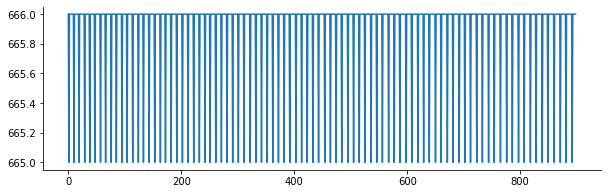

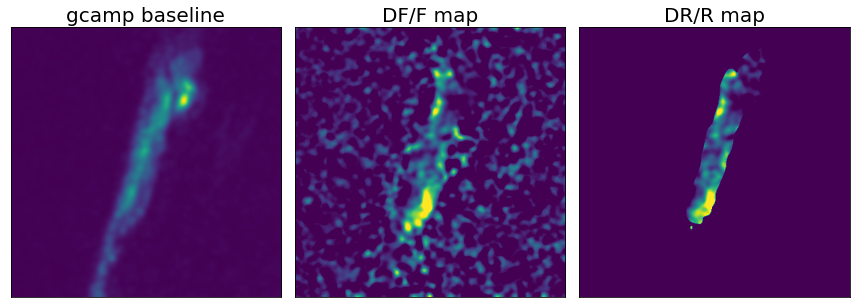

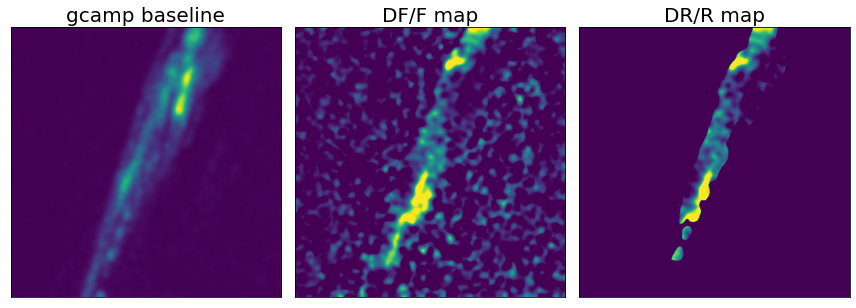

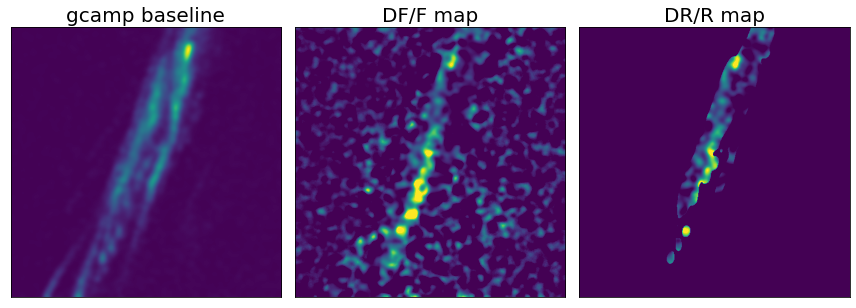

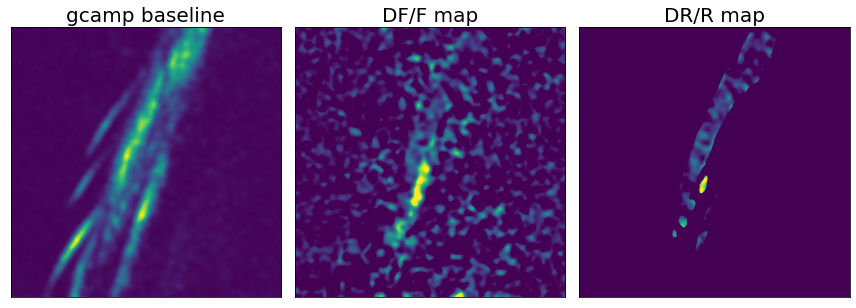

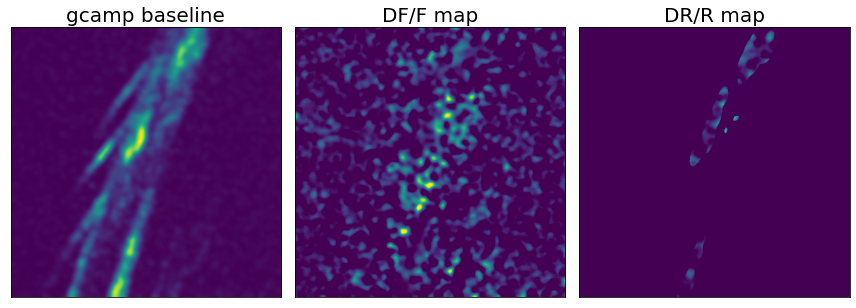

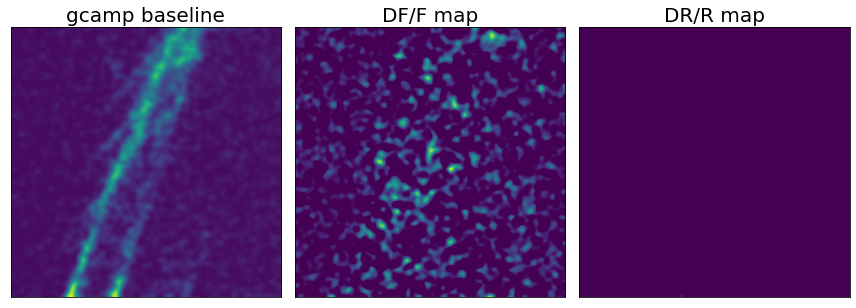

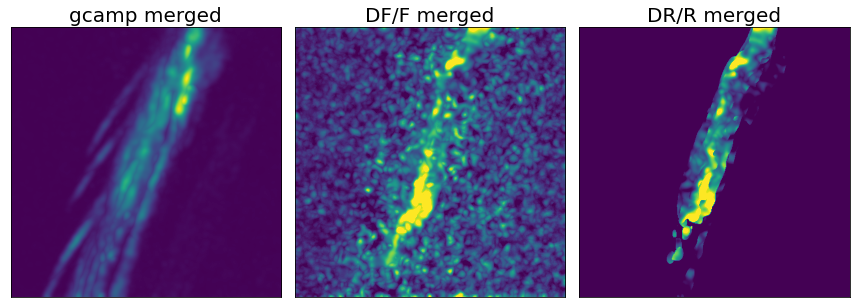

In [ ]:
for trial_index in range(len(image_file_path_sorted)):
  # create image_preprocessing_separate_z object from the class.
  piezo_recording = image_preprocessing_separate_z(image_file_path_sorted[trial_index],frames_data_file_path_sorted[trial_index],outfile_name)

  # create filtered data using the method (for each z-level)
  piezo_recording.filter_ScanImageFile_separate_z()

  # register the images at each z-level
  piezo_recording.motion_correction_separate_z()

  #detect frames for the piezo start
  piezo_recording.detect_piezo_start_frames()

  #Plot the DF/F and DR/R map
  piezo_recording.get_piezo_response_map_separate_z()

  #make an plot the merged map
  piezo_recording.merge_piezo_response_map()

### Select the ROI (dendrites) in the response images.

### Get the path to all the individual z-level maps files (we should have one 800 Hz trial for 50% amplitude) 

In [ ]:
#Get the file path to the merged DF/F map data.
maps_path=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_maps'):
        maps_path.append(os.path.join(path,file_name))
        
maps_path_sorted=sorted(maps_path)

#Print to make sure
for f in maps_path_sorted:
    print(f)

print(len(maps_path_sorted))

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_maps
1


### Use the newly defined function to load the data and initialize the mask:


In [ ]:
#load the merged maps.
trial_number = 0    
DFF_mask = load_DF_F_mask(maps_path_sorted[trial_number])

### Go through each map and select ROI for each one; one ROI for each z-level. Here we show for one z-level.

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

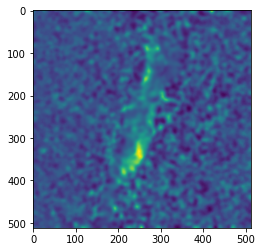

In [ ]:
%matplotlib inline
z_level=0
#select ROI
print('select the ROI')
roi_polygon=ROI_tip_select(DFF_mask['DFF'][z_level,:,:])

In [ ]:
### For online test, have a polygon specified manually.
roi_polygon.selected_points = [[100,100],[100,450],[450,450],[450,100]]

In [ ]:
### Add the selected region to the mask
DFF_mask['mask'] = add_to_mask(ROI_tip_select, DFF_mask['mask'], z_level)

### Run for all the z-levels

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

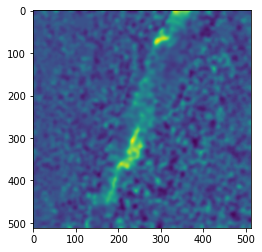

In [ ]:
%matplotlib inline
z_level=1
#select ROI
print('select the ROI')
roi_polygon=ROI_tip_select(DFF_mask['DFF'][z_level,:,:])

In [ ]:
### For online test, have a polygon specified manually.
roi_polygon.selected_points = [[100,100],[100,450],[450,450],[450,100]]
### Add the selected region to the mask
DFF_mask['mask'] = add_to_mask(ROI_tip_select, DFF_mask['mask'], z_level)

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

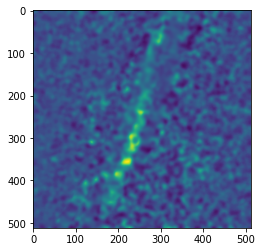

In [ ]:
%matplotlib inline
z_level=2
#select ROI
print('select the ROI')
roi_polygon=ROI_tip_select(DFF_mask['DFF'][z_level,:,:])

In [ ]:
### For online test, have a polygon specified manually.
roi_polygon.selected_points = [[100,100],[100,450],[450,450],[450,100]]
### Add the selected region to the mask
DFF_mask['mask'] = add_to_mask(ROI_tip_select, DFF_mask['mask'], z_level)

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

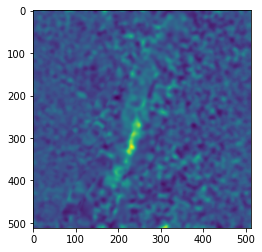

In [ ]:
%matplotlib inline
z_level=3
#select ROI
print('select the ROI')
roi_polygon=ROI_tip_select(DFF_mask['DFF'][z_level,:,:])

In [ ]:
### For online test, have a polygon specified manually.
roi_polygon.selected_points = [[100,100],[100,450],[450,450],[450,100]]
### Add the selected region to the mask
DFF_mask['mask'] = add_to_mask(ROI_tip_select, DFF_mask['mask'], z_level)

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

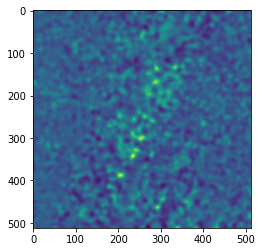

In [ ]:
%matplotlib inline
z_level=4
#select ROI
print('select the ROI')
roi_polygon=ROI_tip_select(DFF_mask['DFF'][z_level,:,:])

In [ ]:
### For online test, have a polygon specified manually.
roi_polygon.selected_points = [[100,100],[100,450],[450,450],[450,100]]
### Add the selected region to the mask
DFF_mask['mask'] = add_to_mask(ROI_tip_select, DFF_mask['mask'], z_level)

select the ROI


Button(description='Disconnect mpl', style=ButtonStyle())

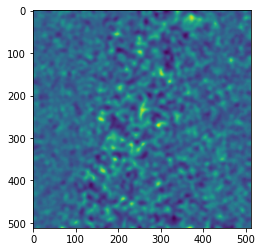

In [ ]:
%matplotlib inline
z_level=5
#select ROI
print('select the ROI')
roi_polygon=ROI_tip_select(DFF_mask['DFF'][z_level,:,:])

In [ ]:
### For online test, have a polygon specified manually.
roi_polygon.selected_points = [[100,100],[100,450],[450,450],[450,100]]
### Add the selected region to the mask
DFF_mask['mask'] = add_to_mask(ROI_tip_select, DFF_mask['mask'], z_level)

### Convert to logical array and save the ROI_masks

In [ ]:
save_mask(DFF_mask['mask'], maps_path_sorted, trial_number)

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_maps_ROI_Z


### Calculate the response center

### Get the path to all the maps files



In [ ]:
#Get the file path to the merged DF/F map data.
maps_path=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_maps'):
        maps_path.append(os.path.join(path,file_name))
        
maps_path_sorted=sorted(maps_path)

#Print to make sure
for f in maps_path_sorted:
    print(f)

print(len(maps_path_sorted))

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_maps
1


In [ ]:
#Get the file path to the merged DF/F map data.
merged_maps_path=[]
#Path for the mered map files

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*maps_merged'):
        merged_maps_path.append(os.path.join(path,file_name))
        
merged_maps_path_sorted=sorted(merged_maps_path)

#Print to make sure
for f in merged_maps_path_sorted:
    print(f)

print(len(merged_maps_path_sorted))

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_maps_merged
1


### get the path to the ROI file

In [ ]:

#Get the file path to the merged DF/F map data.
ROI_files_path=[]

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*_ROI_Z'):
        ROI_files_path.append(os.path.join(path,file_name))
        
ROI_files_path_sorted=sorted(ROI_files_path)

#Print to make sure
for f in ROI_files_path_sorted:
    print(f)



/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_maps_ROI_Z


(286.5461067055593, 250.5519145298255)


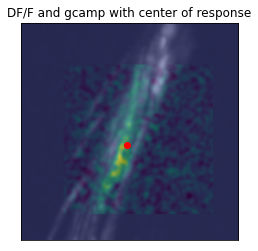

In [ ]:
%matplotlib inline
for trial_file in maps_path_sorted:
  #go through each trial
  calculate_center_of_response(ROI_files_path_sorted[0], trial_file, merged_maps_path_sorted[0],4)

### Select dendritic tips and dendrite ROIs. (for aligning the responses)

* can't run this online.



### Get the path to all the aligned DF/F merged maps (for 800 Hz only). 

In [ ]:
#Get the file path to the merged DF/F map data.
response_maps_path=[]
#Path for the mered map files

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*response_center'):
        response_maps_path.append(os.path.join(path,file_name))
        
response_maps_path_sorted=sorted(response_maps_path)

#Print to make sure
for f in response_maps_path_sorted:
    print(f)

print(len(response_maps_path_sorted))

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_mapsresponse_center
1


### Go through each map and select dendritic tip from the right and then left

In [ ]:
#load the response map.
trial_number = 0
base_gcamp_projection = load_response_map(response_maps_path_sorted[trial_number])

select the most right dendritic tip and then the most left dendritic tip


Button(description='Disconnect mpl', style=ButtonStyle())

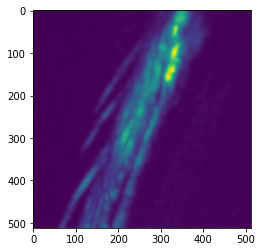

In [ ]:
%matplotlib inline
#select dendritic tips from the right and then left.
print('select the most right dendritic tip and then the most left dendritic tip')
roi_polygon=ROI_tip_select(base_gcamp_projection)


### For online testing, specify the selected points.

In [ ]:
#We have x (count from the left) and Y coordinates (count from the top) for each point. First the right edge, then the left edge.
roi_polygon.selected_points = [[227.66450216450218, 336.8722943722943],
 [143.16233766233765, 411.6774891774891]]

### Save the tip locations

In [ ]:
save_tip_location(roi_polygon, response_maps_path_sorted[trial_number])

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of Copy of 20210823-4-Iav-tdt-7F_00008GCaMP_Filtered_Zs_registered_Zs_mapsresponse_center_tip


### Rotate the response centers to align all the preps

In [ ]:
#Get the file path to the femur angle data
angle_file_path=[]


#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'*.xlsx'):
        angle_file_path.append(os.path.join(path,file_name))
        
angle_file_path_sorted=sorted(angle_file_path)

#Print to make sure
for f in angle_file_path_sorted:
    print(f)

print(len(angle_file_path_sorted))

/content/drive/My Drive/Analysis/test/Biomechanics_test/vibration_responses/Copy of dendrite_tip_angle.xlsx
1


### Get the path to all the data folders

In [ ]:
#Get the path to all the folders that contain data
folder_path=[]
#Path for the mered map files
#Path for the image files

#Go through all the files in a directory
for file_name in os.listdir(path):
    if fnmatch.fnmatch(file_name,'2021*'):
        folder_path.append(os.path.join(path,file_name))
        
folder_path_sorted=sorted(folder_path)

#Print to make sure
for f in folder_path_sorted:
    print(f)

print(len(folder_path_sorted))

/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210712-1
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210712-2
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210713-1
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210713-2
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210715-1
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210720-1
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210720-2
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210722-4
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration/20210712_1_0823_4/20210723-2
/content/drive/Shared drives/Akira_LegImagingData/Analysis/club_vibration

### Load the angle data and get the rotation radian (angle to rotate to make them align)

* we have already removed the 20210823-1

In [ ]:
rotation_rad = get_rotation_rad(angle_file_path_sorted[0])

0    -1.244420
1    -0.724312
2    -1.130973
3    -1.153663
4    -1.003564
5    -1.335177
6    -1.268854
7    -1.097812
8    -1.017527
9    -1.050688
10   -1.308997
11   -0.958186
12   -1.226966
13   -1.117011
14   -1.160644
15   -1.190315
16   -1.389282
Name: dendrite_angle, dtype: float64


### Run for all the Iav x tdt; 7F flies we have (up till 20210823-4); new response center files have the name "mapsresponse_center"

* currently don't have all the folder and data in the test directory.
* test later.

In [ ]:
align_all_responses(path, folder_path_sorted, rotation_rad)

### Calculate the average response for each frequency

0.16623461681765106
(48488,)


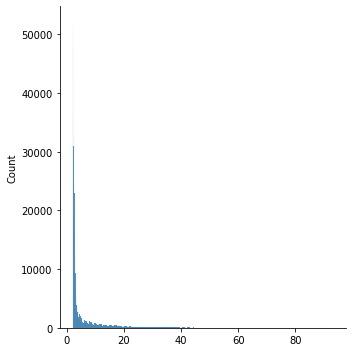

In [ ]:
%matplotlib inline
for trial_file in maps_path_sorted:
  #go through each trial
  calculate_average_response(ROI_files_path_sorted[0], trial_file, merged_maps_path_sorted[0],4,gcamp_threshold=20)

### Make a plot of responses vs frequency

In [ ]:
#We need this to export Type2/True Type fonts when exporting figure
matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['ps.fonttype']=42
matplotlib.rcParams['xtick.direction']='in'
matplotlib.rcParams['ytick.direction']='in'


### Collect all the response data

* currently don't have all the response data in the test directory.
* Make a directory later for the example analyses.

In [ ]:
freq_response_data = collect_response_vs_frequency(folder_path_sorted)

### Plot the data

* next box should plot the same figure as the one copied below.

In [ ]:
make_response_vs_freq_plot(freq_response_data, path)

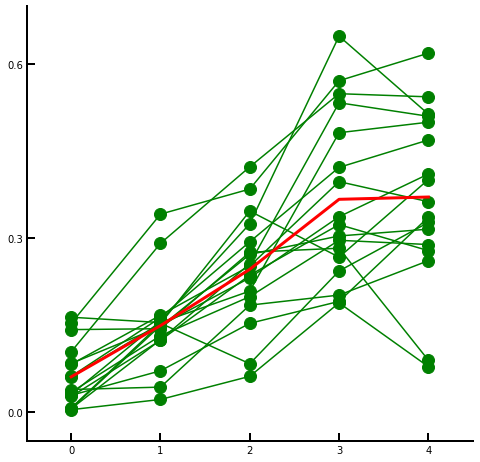

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(freq_response_data[0:5,:],'go-',linewidth=1.5, markersize=12)
ax.plot(np.average(freq_response_data[0:5,:],axis=1),'r',linewidth=3)

ax.set_xlim([-0.5,4.5])
ax.set_ylim([-0.05,0.7])
ax.set_yticks([0, 0.3, 0.6])
#plt.ylabel('distance from the center (microns)', fontsize = 14)
#plt.xlabel('distance from the center (microns)', fontsize=14)
ax.tick_params(direction='in', length = 8, width=2)
ax.spines['left'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)
sns.despine(fig=fig,ax=ax)
#plt.show()
plt.savefig(path+"/club_frquency_tuning_curve_new.pdf",transparent=True)

### For making example DF/F maps
* currently don't have all the data in the test directory.
* the next box should produce the same output as the one below.

In [ ]:
make_example_response_map(response_maps_path_sorted)

### Load each one and show the example image (from 200-2000 Hz).

* change the color of the response center based on the frequency.

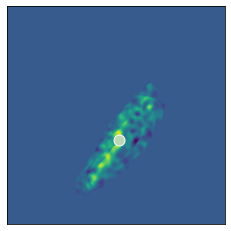

(314.34275291057645, 263.55792345122705)


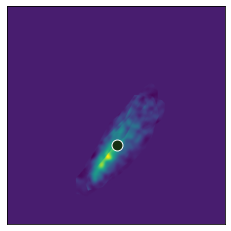

(326.9974453651547, 257.56343445163554)


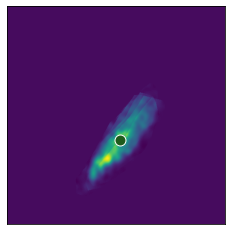

(315.07784847902053, 265.47109575918336)


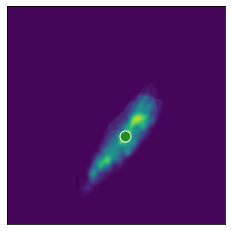

(305.15269384738156, 277.4845687542334)


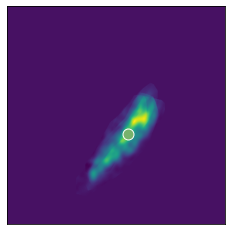

(299.1562757312218, 283.9812927719248)


In [ ]:
response_center_colors=['#172f13','#1f5b1c','#228b22', '#77b26b','#bbd8b3']

#start from the 100 Hz (first trial) now, and don't use the 2 kHz

stim_n = 0

while stim_n < 5:
  data_file=response_maps_path_sorted[stim_n]    
  #load the appropriate data
  with open(data_file,'rb') as f:
    [base_gcamp_projection, DF_F_projection, response_center]=pickle.load(f)
  
  #show the image with the appropriate response center
  fig,ax = plt.subplots(1,1)
  
  im2 = plt.imshow(DF_F_projection)
  plt.scatter(response_center[1],response_center[0],c=response_center_colors[stim_n-1],edgecolors='w',s=120)

  ax.set_yticks([])
  ax.set_xticks([])
  #ax.set_title('DF/F with center of response', fontsize=12)
  plt.savefig(data_file+"_DF_F_example_new.pdf",transparent=True)
  
  plt.show()
  print(response_center)

  stim_n=stim_n+1



### Make a summary plot of the response locations

#### collect the response center data and convert to microns

In [ ]:
### all pizeo data is with x4 zoom.
conversion_factor=25/124
response_at_freq = collect_convert_response_center(folder_path_sorted, conversion_factor)

#### Calculate best fit line with PCA

In [ ]:
response_at_freq_PC = get_response_center_PC(response_at_freq)

### Plot the original center of the responses and then overlay the PCA direction line throught the center of all the dots.

* currently don't have all the data in the test directory.
* the following function should produce the same plot as shown below.

In [ ]:
make_response_location_plot(response_at_freq, response_at_freq_PC, path)

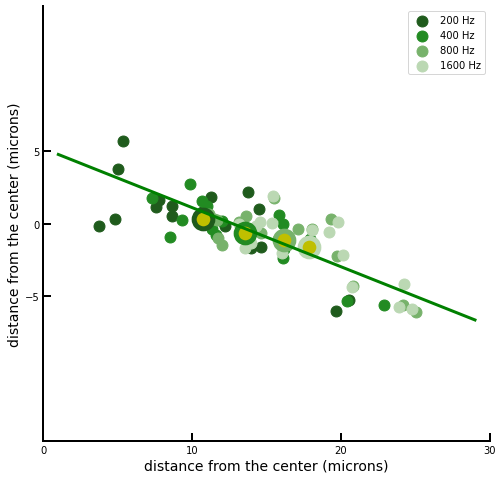

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
#ax.scatter(Freq_100[:,0],Freq_100[:,1],c='b',s=30,label='100 Hz')
#ax.scatter(np.average(Freq_100[:,0]),np.average(Freq_100[:,1]),c='b',s=100,label='100 Hz')
ax.plot([left_point[0],right_point[0]],[left_point[1],right_point[1]],'g',linewidth=3)

ax.scatter(Freq_200[:,0],Freq_200[:,1],c='#1f5b1c',s=120, label='200 Hz')

ax.scatter(Freq_400[:,0],Freq_400[:,1],c='#228b22',s=120, label ='400 Hz')

ax.scatter(Freq_800[:,0],Freq_800[:,1],c='#77b26b',s=120, label = '800 Hz')

ax.scatter(Freq_1600[:,0],Freq_1600[:,1],c='#bbd8b3',s=120, label = '1600 Hz')

#ax.scatter(Freq_2000[:,0],Freq_2000[:,1],c='#bbd8b3',s=120, label = '2000 Hz')

ax.scatter(np.average(Freq_200[:,0]),np.average(Freq_200[:,1]),c='y',edgecolors='#1f5b1c',linewidth=5, s=350)
ax.scatter(np.average(Freq_400[:,0]),np.average(Freq_400[:,1]),c='y', edgecolors='#228b22', linewidths=5,s=350)
ax.scatter(np.average(Freq_800[:,0]),np.average(Freq_800[:,1]),c='y', edgecolors='#77b26b', linewidths=5,s=350)
ax.scatter(np.average(Freq_1600[:,0]),np.average(Freq_1600[:,1]),c='y', edgecolors='#bbd8b3', linewidths=5 ,s=350)
#ax.scatter(np.average(Freq_2000[:,0]),np.average(Freq_2000[:,1]),c='y',edgecolors='#bbd8b3', linewidths=5,s=350)



ax.legend()
ax.set_xlim([0,30])
ax.set_ylim([-15,15])

ax.set_xticks([0,10,20,30])
ax.set_yticks([-5, 0, 5])

ax.tick_params(direction='in', length = 8, width=2)
ax.spines['left'].set_linewidth(2.0)
ax.spines['bottom'].set_linewidth(2.0)

plt.ylabel('distance from the center (microns)', fontsize = 14)
plt.xlabel('distance from the center (microns)', fontsize=14)
sns.despine(fig=fig,ax=ax)
#plt.show()
plt.savefig(path+"/club_vibration_response_center_per_frequency_perFly_new.pdf",transparent=True)

### Calculte the bootstraped distribution and plot it with 95% confidence interval.

* currently do not have all the data in the test directory.
* the following line should make the same plot shown below.

In [ ]:
plot_bootstrap_estimate_response_location(response_at_freq_PC, path)

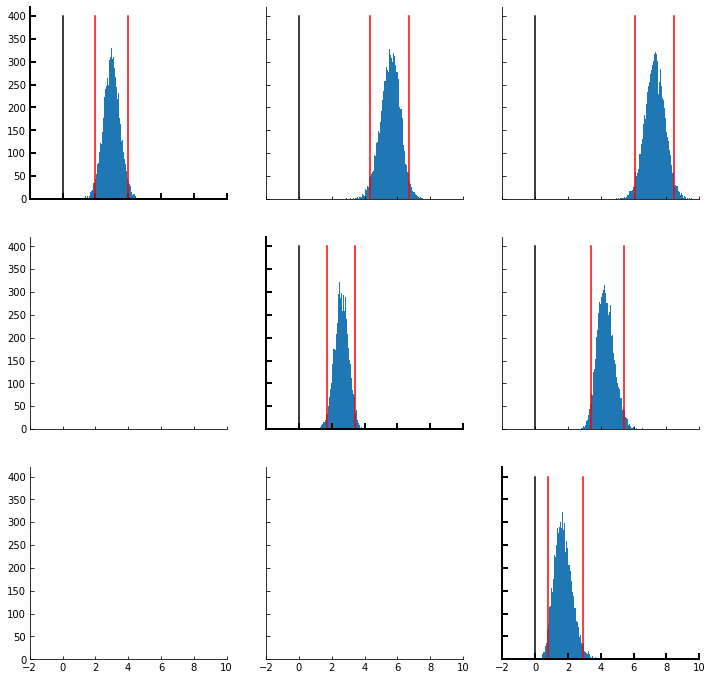

In [ ]:
fig, ax = plt.subplots(3, 3,sharex=True, sharey=True, figsize=(12,12))

#For now just go one by one. [0,0] is the difference between 200 and 400.
bootstrap_results=response_center_difference_bootstrap(Freq_200_PC[:,0],Freq_400_PC[:,0],95,10000)

mean_difference=bootstrap_results['mean_difference']
lower_bound=bootstrap_results['lower_bound']
upper_bound=bootstrap_results['upper_bound']

ax[0,0].hist(mean_difference, bins=100)
ax[0,0].plot([lower_bound,lower_bound],[0,400],c='r')
ax[0,0].plot([upper_bound,upper_bound],[0,400],c='r')
ax[0,0].plot([0,0],[0,400],c='k')
ax[0,0].set_xlim([-2, 10])
ax[0,0].tick_params(direction='in', length = 6, width=2)
ax[0,0].spines['left'].set_linewidth(2.0)
ax[0,0].spines['bottom'].set_linewidth(2.0)

#For now just go one by one. [0,1] is the difference between 200 and 800.
bootstrap_results=response_center_difference_bootstrap(Freq_200_PC[:,0],Freq_800_PC[:,0],95,10000)

mean_difference=bootstrap_results['mean_difference']
lower_bound=bootstrap_results['lower_bound']
upper_bound=bootstrap_results['upper_bound']

ax[0,1].hist(mean_difference, bins=100)
ax[0,1].plot([lower_bound,lower_bound],[0,400],c='r')
ax[0,1].plot([upper_bound,upper_bound],[0,400],c='r')
ax[0,1].plot([0,0],[0,400],c='k')
ax[0,1].set_xlim([-2, 10])

#For now just go one by one. [0,2] is the difference between 200 and 1600.
bootstrap_results=response_center_difference_bootstrap(Freq_200_PC[:,0],Freq_1600_PC[:,0],95,10000)

mean_difference=bootstrap_results['mean_difference']
lower_bound=bootstrap_results['lower_bound']
upper_bound=bootstrap_results['upper_bound']

ax[0,2].hist(mean_difference, bins=100)
ax[0,2].plot([lower_bound,lower_bound],[0,400],c='r')
ax[0,2].plot([upper_bound,upper_bound],[0,400],c='r')
ax[0,2].plot([0,0],[0,400],c='k')
ax[0,2].set_xlim([-2, 10])

#For now just go one by one. [1,1] is the difference between 400 and 800.
bootstrap_results=response_center_difference_bootstrap(Freq_400_PC[:,0],Freq_800_PC[:,0],95,10000)

mean_difference=bootstrap_results['mean_difference']
lower_bound=bootstrap_results['lower_bound']
upper_bound=bootstrap_results['upper_bound']

ax[1,1].hist(mean_difference, bins=100)
ax[1,1].plot([lower_bound,lower_bound],[0,400],c='r')
ax[1,1].plot([upper_bound,upper_bound],[0,400],c='r')
ax[1,1].plot([0,0],[0,400],c='k')
ax[1,1].set_xlim([-2, 10])
ax[1,1].tick_params(direction='in', length = 6, width=2)
ax[1,1].spines['left'].set_linewidth(2.0)
ax[1,1].spines['bottom'].set_linewidth(2.0)
#For now just go one by one. [1,2] is the difference between 400 and 1600.
bootstrap_results=response_center_difference_bootstrap(Freq_400_PC[:,0],Freq_1600_PC[:,0],95,10000)

mean_difference=bootstrap_results['mean_difference']
lower_bound=bootstrap_results['lower_bound']
upper_bound=bootstrap_results['upper_bound']

ax[1,2].hist(mean_difference, bins=100)
ax[1,2].plot([lower_bound,lower_bound],[0,400],c='r')
ax[1,2].plot([upper_bound,upper_bound],[0,400],c='r')
ax[1,2].plot([0,0],[0,400],c='k')
ax[1,2].set_xlim([-2, 10])

#For now just go one by one. [2,2] is the difference between 800 and 1600.
bootstrap_results=response_center_difference_bootstrap(Freq_800_PC[:,0],Freq_1600_PC[:,0],95,10000)

mean_difference=bootstrap_results['mean_difference']
lower_bound=bootstrap_results['lower_bound']
upper_bound=bootstrap_results['upper_bound']

ax[2,2].hist(mean_difference, bins=100)
ax[2,2].plot([lower_bound,lower_bound],[0,400],c='r')
ax[2,2].plot([upper_bound,upper_bound],[0,400],c='r')
ax[2,2].plot([0,0],[0,400],c='k')
ax[2,2].set_xlim([-2, 10])
ax[2,2].tick_params(direction='in', length = 6, width=2)
ax[2,2].spines['left'].set_linewidth(2.0)
ax[2,2].spines['bottom'].set_linewidth(2.0)

#ax[1].plot(time_axis,norm_DRR)
sns.despine(fig=fig,ax=ax)

plt.savefig(path+"/club_vibration_response_center_difference_new.pdf",transparent=True)